# Prognozowanie oglądalności dla stacji telewizyjnej z wykorzystaniem szeregów czasowych.

# 1. Wstęp

# 2. Wykorzystywane biblioteki i metody

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from tqdm.autonotebook import tqdm
from darts.models.forecasting.gradient_boosted_model import LightGBMModel
import darts as darts
import pickle

import lightgbm as lgbm
from lightgbm import LGBMRegressor
import re

import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import scipy.stats as st
import pingouin as pg
#jeśli wyrzuci błąd problemu z importem croston, to ponowić uruchomienie

# 3. Wczytywanie danych wraz z ich oczyszczaniem i wstępnym przygotowaniem do analizy

In [3]:
data = pd.read_csv("Programmes monthly ranking factual 2017-2022.txt")
data = data.drop("Target", axis=1)

In [4]:
data = pd.DataFrame(data)
data = data[:-1] #ostatni wiersz to podsumowanie
data

Channel Group ...        Date Start time            Programme Title  \
0                   History  2017-12-22   02:00:00             Wykute w ogniu   
1                   History  2017-12-22   02:27:00                 Ludzie gor   
2                   History  2017-12-22   03:11:00           Gwiazdy lombardu   
3                   History  2017-12-22   03:32:00           Wojny magazynowe   
4                   History  2017-12-22   03:55:00             Wykute w ogniu   
...                     ...         ...        ...                        ...   
1403571  Discovery Historia  2022-12-21   22:00:00  Nowe zycie starych rzeczy   
1403572  Discovery Historia  2022-12-21   22:30:00  Nowe zycie starych rzeczy   
1403573  Discovery Historia  2022-12-21   23:00:00             Historia oreza   
1403574  Discovery Historia  2022-12-21   24:00:00    Miecze z szalonej kuzni   
1403575  Discovery Historia  2022-12-21   25:00:00    Miecze z szalonej kuzni   

         '000 (avg)  Prog Share  
0             0.000       0.000  
1             0.000       0.000  
2             0.000       0.000  
3             3.234       0.499  
4             0.000       0.000  
...             ...         ...  
1403571       2.308       0.042  
1403572       8.183       0.176  
1403573       4.417       0.125  
1403574       2.930       0.141  
1403575       0.000       0.000  

[1403576 rows x 6 columns]

In [5]:
data["Date"] = pd.to_datetime(data["Date"]) #konwersja typu kolumny do daty i okresu

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403576 entries, 0 to 1403575
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Channel Group ...  1403576 non-null  object        
 1   Date               1403576 non-null  datetime64[ns]
 2   Start time         1403576 non-null  object        
 3   Programme Title    1403576 non-null  object        
 4   '000 (avg)         1403576 non-null  float64       
 5   Prog Share         1403576 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 64.3+ MB


In [7]:
# dorzucane dwie nowe kolumny do przeróbki na rzeczywiste daty i godziny emisji
data.insert(1, "Start_time_real", "") 
data.insert(1, "Date_real", "") 

In [8]:
for i in data.index:
    if data["Start time"][i][:2] == '24':
        a = ("00" + data["Start time"][i][2:])
        b = data["Date"][i] + timedelta(days=1)
        data.at[i, 'Start_time_real'] = a
        data.at[i, 'Date_real'] = b
    elif data["Start time"][i][:2] == '25':
        a = ("01" + data["Start time"][i][2:])
        b = data["Date"][i] + timedelta(days=1)
        data.at[i, 'Start_time_real'] = a
        data.at[i, 'Date_real'] = b       
    else:
        a = data["Start time"][i]
        b = data["Date"][i]
        data.at[i, 'Start_time_real'] = a
        data.at[i, 'Date_real'] = b
# df.at pozwala na podstawienie obiektu do istniejących już kolumn ramki

In [9]:
data['Date_real'] = pd.to_datetime(data['Date_real'])

In [10]:
data["Date_time"] = pd.to_datetime(data['Date_real'] + pd.to_timedelta(data["Start_time_real"]))

In [11]:
work = data

In [12]:
work = work.drop('Date', axis = 1)
work = work.drop('Start time', axis = 1)
work = work.rename(columns={"Channel Group ...": "Channel", "Prog Share": "Share", "Programme Title": "Title", "'000 (avg)": "Audience"})                   

In [13]:
work["Title"].str.contains("Blad").value_counts()

False    1401738
True        1838
Name: Title, dtype: int64

In [14]:
work = work[work["Title"].str.contains("Blad") == False]  # czyszczenie danych z błędów emisyjnych

In [15]:
work["Title"].str.contains("Blad").value_counts()

False    1401738
Name: Title, dtype: int64

In [16]:
def tb_func(tb):
    x = tb.hour   
    if x < 3:
        x = 'band 0-3'
    elif (3 <= x < 6):
        x = 'band 3-6'    
    elif (6 <= x < 9):
        x = 'band 6-9'
    elif (9 <= x < 12):
        x = 'band 9-12'
    elif (12 <= x < 15):
        x = 'band 12-15'
    elif (15 <= x < 18):
        x = 'band 15-18'   
    elif (18 <= x < 21):
        x = 'band 18-21'    
    elif x >= 21:
        x = 'band 21-24'    
    return x

work['time_band'] = work['Date_time'].apply(tb_func) # podział na pasma w ciągu dnia

In [17]:
def day_func(Day):
    return Day.strftime("%A")

work['Day_of_week'] = work['Date_time'].apply(day_func) # dodanie feature'a do sprawdzenia zależności share od dnia tygodnia

In [18]:
work

Channel  Date_real Start_time_real  \
0                   History 2017-12-22        02:00:00   
1                   History 2017-12-22        02:27:00   
2                   History 2017-12-22        03:11:00   
3                   History 2017-12-22        03:32:00   
4                   History 2017-12-22        03:55:00   
...                     ...        ...             ...   
1403571  Discovery Historia 2022-12-21        22:00:00   
1403572  Discovery Historia 2022-12-21        22:30:00   
1403573  Discovery Historia 2022-12-21        23:00:00   
1403574  Discovery Historia 2022-12-22        00:00:00   
1403575  Discovery Historia 2022-12-22        01:00:00   

                             Title  Audience  Share           Date_time  \
0                   Wykute w ogniu     0.000  0.000 2017-12-22 02:00:00   
1                       Ludzie gor     0.000  0.000 2017-12-22 02:27:00   
2                 Gwiazdy lombardu     0.000  0.000 2017-12-22 03:11:00   
3                 Wojny magazynowe     3.234  0.499 2017-12-22 03:32:00   
4                   Wykute w ogniu     0.000  0.000 2017-12-22 03:55:00   
...                            ...       ...    ...                 ...   
1403571  Nowe zycie starych rzeczy     2.308  0.042 2022-12-21 22:00:00   
1403572  Nowe zycie starych rzeczy     8.183  0.176 2022-12-21 22:30:00   
1403573             Historia oreza     4.417  0.125 2022-12-21 23:00:00   
1403574    Miecze z szalonej kuzni     2.930  0.141 2022-12-22 00:00:00   
1403575    Miecze z szalonej kuzni     0.000  0.000 2022-12-22 01:00:00   

          time_band Day_of_week  
0          band 0-3      Friday  
1          band 0-3      Friday  
2          band 3-6      Friday  
3          band 3-6      Friday  
4          band 3-6      Friday  
...             ...         ...  
1403571  band 21-24   Wednesday  
1403572  band 21-24   Wednesday  
1403573  band 21-24   Wednesday  
1403574    band 0-3    Thursday  
1403575    band 0-3    Thursday  

[1401738 rows x 9 columns]

# 4. Grupowanie danych celem ustalenia potencjalnego wpływu na wyniki oglądalności

## 4.1 Sprawdzenie zrożnicowania średniej oglądalności wszystkich stacji w poszczególnych dniach.

In [20]:
weekday_avg_aud = work.groupby('Day_of_week')['Audience'].mean().reset_index() # średnia oglądalność w poszczególnych dniach
weekday_avg_aud = pd.DataFrame(weekday_avg_aud)
weekday_avg_aud

Day_of_week   Audience
0      Friday  12.704358
1      Monday  12.799383
2    Saturday  14.789853
3      Sunday  21.480364
4    Thursday  12.963582
5     Tuesday  12.509920
6   Wednesday  12.604528

## 4.2 Sprawdzenie zróżnicowania średniej oglądalności w zależności od pasma programowego (podział co 3 godziny).

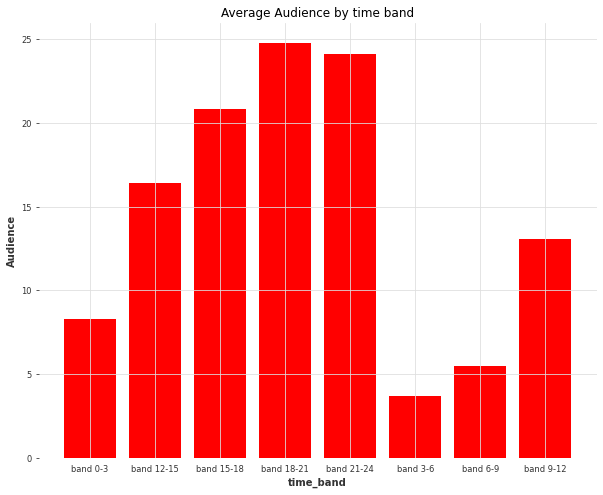

In [273]:
band_avg_aud = work.groupby('time_band')['Audience'].mean().reset_index() # średnia oglądalność w poszczególnych pasmach dnia
band_avg_aud = pd.DataFrame(band_avg_aud)
band_avg_aud

fig2, bx2 = plt.subplots(figsize=(10, 8)) 
bx2.bar(band_avg_aud['time_band'], band_avg_aud['Audience'], color='red')
bx2.set_xlabel('time_band') 
bx2.set_ylabel('Audience') 
bx2.set_title('Average Audience by time band') 

plt.show()

## 4.3 Tworzenie ramki danych określającej dany tytuł jako heat (ponad przeciętna oglądalność). 

In [24]:
title_avg_shr = work.groupby('Title')['Share'].mean().reset_index() 
heat_titles = pd.DataFrame(title_avg_shr)
heat_titles

Title     Share
0     #chicagogirl - facebookowa rewolucja  0.044000
1                         #jestem m misfit  0.229278
2                             #liniaprosta  0.294787
3                          #piatkadlarysia  0.223189
4                     #tvn pomagajmy sobie  0.299625
...                                    ...       ...
8718            Zywioly ktore niosa smierc  0.118828
8719                           Zywnosc 3.0  0.047500
8720                         Zywnosc jutra  0.139694
8721                         Zywot michala  0.203429
8722                             Zza plotu  0.011889

[8723 rows x 2 columns]

In [25]:
title_avg_shr.sort_values(['Share'])

Title     Share
7593                    Uwaga mister baker  0.000000
662   Bo jestem geniuszem lorenza mazzetti  0.000000
4802                         Odkryc prawde  0.000000
180              Afryka mojego dziecinstwa  0.000000
2731                       Jestesmy w raju  0.000000
...                                    ...       ...
6009               Rozmiar xxl na sprzedaz  4.159000
611                       Bilet na ksiezyc  4.616500
6353                         Slady zbrodni  4.713333
599                   Bierz forse i w nogi  4.762000
4068          Morderstwo w domku dla lalek  4.817000

[8723 rows x 2 columns]

In [27]:
avg_shr = title_avg_shr['Share'].mean()
avg_shr

0.33556843353577087

In [28]:
def heat_func(share):
    if share >= avg_shr:
        x = 1
    else:
        x = 0 
    return x

heat_titles['Heat'] = heat_titles['Share'].apply(heat_func)

In [29]:
heat_titles.tail(60)

Title     Share  Heat
8663                     Zwyciezcy i przegrani  0.021500     0
8664  Zwyciezcy nie umieraja opowiesc o ksiedz  0.000000     0
8665                            Zwyczajny kraj  0.172667     0
8666         Zwykle rzeczy niezwykle wynalazki  0.281967     0
8667   Zwykle rzeczy niezwykle wynalazki sport  0.023000     0
8668                         Zwykle zaburzenie  0.096800     0
8669                           Zyc nie umierac  0.152889     0
8670                 Zycia nie mozna zmarnowac  0.072000     0
8671                             Zycie baltyku  0.668538     1
8672                      Zycie bez happy endu  0.050375     0
8673        Zycie bez rak historia jessiki cox  0.127667     0
8674       Zycie lasu bogactwo runa i podszytu  0.278375     0
8675                         Zycie lasu grzyby  0.128000     0
8676                          Zycie lasu ptaki  0.317333     0
8677                      Zycie lasu storczyki  0.376800     1
8678                           Zycie na alasce  0.204025     0
8679                   Zycie na cienkiej linie  0.210000     0
8680                         Zycie na krawedzi  0.360552     1
8681                       Zycie na tafli lodu  0.619409     1
8682                       Zycie na trawlerach  1.018167     1
8683                     Zycie nelsona mandeli  0.051563     0
8684                         Zycie pierwotnych  0.310800     0
8685                           Zycie po cudzie  0.094333     0
8686                  Zycie po zagladzie ludzi  0.154544     0
8687                            Zycie pod woda  0.000000     0
8688                        Zycie przed oczami  1.480067     1
8689                          Zycie przed toba  0.055000     0
8690                     Zycie to cos pieknego  0.010000     0
8691                          Zycie w blekicie  0.131200     0
8692  Zycie w drodze medycyna mongolskich step  0.170750     0
8693      Zycie w drodze ostatnie mobilne kino  0.113250     0
8694                            Zycie w dziczy  0.480651     1
8695                          Zycie w kosmosie  0.373857     1
8696          Zycie w piecdziesieciu stopniach  0.179200     0
8697                         Zycie w powietrzu  0.146000     0
8698                         Zycie w wiezieniu  0.560000     1
8699                      Zycie z efektem wow!  0.494050     1
8700                          Zycie za kolkiem  0.857437     1
8701                Zycie zaczyna sie od tanca  0.036000     0
8702    Zyciodajne rzeki polwyspu iberyjskiego  0.187029     0
8703                                  Zyciorys  0.034000     0
8704                    Zyciorys jak z orwella  0.021000     0
8705                       Zyczenia swiateczne  0.012140     0
8706                        Zyczenie smierci v  0.742500     1
8707             Zydzi w powstaniu warszawskim  0.071500     0
8708      Zygmunt hubner gra z rzeczywistoscia  0.080167     0
8709                         Zygmunt konieczny  0.000000     0
8710                         Zyjac z tourettem  0.406857     1
8711  Zylem jak chcialem... gen. stanislaw ska  0.044511     0
8712                      Zylismy tylko muzyka  0.018600     0
8713                     Zyrafa swiat z wysoka  0.134545     0
8714   Zywe pomniki najstarsze drzewa w polsce  0.172000     0
8715                                    Zywiol  0.454833     1
8716                           Zywioly atakuja  0.341500     1
8717                       Zywioly grochowiaka  0.000000     0
8718                Zywioly ktore niosa smierc  0.118828     0
8719                               Zywnosc 3.0  0.047500     0
8720                             Zywnosc jutra  0.139694     0
8721                             Zywot michala  0.203429     0
8722                                 Zza plotu  0.011889     0

In [31]:
channel_avg_shr = work.groupby('Channel')['Share'].mean().sort_values() 
channel_avg_shr

Channel
Polsat Games             0.040729
TVP Dokument             0.091259
BBC Brit                 0.094470
Discovery Historia       0.112552
History2 [H2]            0.132355
BBC Earth                0.159274
Polsat Viasat Explore    0.187947
Polsat Viasat History    0.257810
Discovery Science        0.275614
National Geographic      0.420973
History                  0.429808
Zoom TV                  0.555794
Polsat Play              0.602589
Discovery pl             0.629033
WP                       0.681939
TVN Turbo                0.765775
Fokus TV                 1.159488
Name: Share, dtype: float64

In [32]:
channel_avg_shr = work.groupby('Channel')['Share'].mean().reset_index() 
channel_avg_shr = pd.DataFrame(channel_avg_shr)
channel_avg_shr

Channel     Share
0                BBC Brit  0.094470
1               BBC Earth  0.159274
2      Discovery Historia  0.112552
3       Discovery Science  0.275614
4            Discovery pl  0.629033
5                Fokus TV  1.159488
6                 History  0.429808
7           History2 [H2]  0.132355
8     National Geographic  0.420973
9            Polsat Games  0.040729
10            Polsat Play  0.602589
11  Polsat Viasat Explore  0.187947
12  Polsat Viasat History  0.257810
13              TVN Turbo  0.765775
14           TVP Dokument  0.091259
15                     WP  0.681939
16                Zoom TV  0.555794

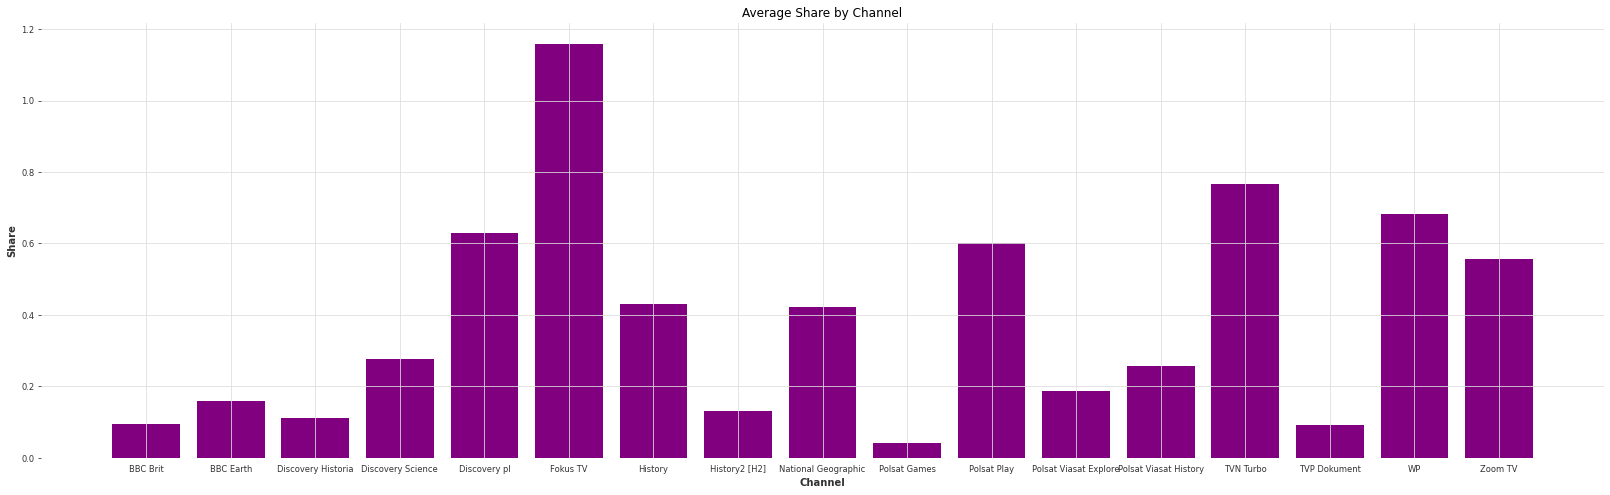

In [279]:
fig3, bx3 = plt.subplots(figsize=(28, 8)) 
bx3.bar(channel_avg_shr['Channel'], channel_avg_shr['Share'], color='purple')
bx3.set_xlabel('Channel') 
bx3.set_ylabel('Share') 
bx3.set_title('Average Share by Channel') 

plt.show()

In [34]:
title_channel_shr = work.groupby(['Title','Channel'])['Share'].mean()
title_channel_shr

Title                                 Channel            
#chicagogirl - facebookowa rewolucja  TVP Dokument           0.044000
#jestem m misfit                      Polsat Games           0.009439
                                      Polsat Play            0.609000
#liniaprosta                          History                0.294787
#piatkadlarysia                       National Geographic    0.223189
                                                               ...   
Zywioly ktore niosa smierc            History2 [H2]          0.118828
Zywnosc 3.0                           TVP Dokument           0.047500
Zywnosc jutra                         TVP Dokument           0.139694
Zywot michala                         TVP Dokument           0.203429
Zza plotu                             TVP Dokument           0.011889
Name: Share, Length: 9735, dtype: float64

In [35]:
work.groupby('Channel')['Share'].describe()

count      mean       std  min    25%    50%    75%  \
Channel                                                                         
BBC Brit                46815.0  0.094470  0.240331  0.0  0.000  0.010  0.091   
BBC Earth               48491.0  0.159274  0.322483  0.0  0.000  0.042  0.180   
Discovery Historia      59143.0  0.112552  0.273309  0.0  0.000  0.014  0.108   
Discovery Science       71866.0  0.275614  0.452456  0.0  0.016  0.128  0.342   
Discovery pl            51919.0  0.629033  0.686551  0.0  0.165  0.444  0.860   
Fokus TV               122754.0  1.159488  1.193825  0.0  0.454  0.892  1.483   
History                 74022.0  0.429808  0.643947  0.0  0.034  0.234  0.569   
History2 [H2]           47402.0  0.132355  0.316290  0.0  0.000  0.023  0.144   
National Geographic     50130.0  0.420973  0.542777  0.0  0.099  0.269  0.541   
Polsat Games           100923.0  0.040729  0.161432  0.0  0.000  0.000  0.000   
Polsat Play            157380.0  0.602589  0.698619  0.0  0.107  0.421  0.856   
Polsat Viasat Explore   60236.0  0.187947  0.423695  0.0  0.000  0.042  0.196   
Polsat Viasat History   62573.0  0.257810  0.464621  0.0  0.000  0.100  0.308   
TVN Turbo              151995.0  0.765775  0.762277  0.0  0.184  0.589  1.125   
TVP Dokument            24629.0  0.091259  0.168507  0.0  0.000  0.023  0.112   
WP                     127704.0  0.681939  0.921885  0.0  0.121  0.409  0.852   
Zoom TV                143756.0  0.555794  0.850709  0.0  0.019  0.290  0.715   

                          max  
Channel                        
BBC Brit                6.565  
BBC Earth               7.475  
Discovery Historia      6.155  
Discovery Science       8.597  
Discovery pl            8.484  
Fokus TV               18.031  
History                12.340  
History2 [H2]           7.229  
National Geographic    13.823  
Polsat Games            8.609  
Polsat Play            12.673  
Polsat Viasat Explore   9.659  
Polsat Viasat History  11.020  
TVN Turbo              14.860  
TVP Dokument            3.662  
WP                     14.833  
Zoom TV                19.950

In [36]:
work.groupby('Title')['Share'].describe()

count      mean       std    min  \
Title                                                                    
#chicagogirl - facebookowa rewolucja    4.0  0.044000  0.032166  0.012   
#jestem m misfit                       90.0  0.229278  0.508200  0.000   
#liniaprosta                          287.0  0.294787  0.337588  0.000   
#piatkadlarysia                        90.0  0.223189  0.305662  0.000   
#tvn pomagajmy sobie                  277.0  0.299625  0.602546  0.000   
...                                     ...       ...       ...    ...   
Zywioly ktore niosa smierc            239.0  0.118828  0.389018  0.000   
Zywnosc 3.0                             6.0  0.047500  0.034315  0.010   
Zywnosc jutra                          36.0  0.139694  0.163489  0.000   
Zywot michala                           7.0  0.203429  0.484094  0.000   
Zza plotu                               9.0  0.011889  0.032088  0.000   

                                          25%     50%      75%    max  
Title                                                                  
#chicagogirl - facebookowa rewolucja  0.02700  0.0380  0.05500  0.088  
#jestem m misfit                      0.00000  0.0000  0.12425  2.961  
#liniaprosta                          0.00000  0.1590  0.44350  1.481  
#piatkadlarysia                       0.00000  0.0745  0.37950  1.449  
#tvn pomagajmy sobie                  0.00000  0.0080  0.45900  7.156  
...                                       ...     ...      ...    ...  
Zywioly ktore niosa smierc            0.00000  0.0070  0.08650  5.124  
Zywnosc 3.0                           0.01750  0.0470  0.07200  0.093  
Zywnosc jutra                         0.00925  0.0565  0.22650  0.574  
Zywot michala                         0.00000  0.0130  0.05600  1.299  
Zza plotu                             0.00000  0.0000  0.00000  0.097  

[8723 rows x 8 columns]

## 4.4 Wydzielenie osobnej ramki dla kanału dedykowanego do predykcji.

In [37]:
History = work[work["Channel"] == "History"] 
History = History.drop(['Start_time_real','Channel'], axis = 1)
History.head(60)

Date_real                       Title  Audience  Share  \
0  2017-12-22              Wykute w ogniu     0.000  0.000   
1  2017-12-22                  Ludzie gor     0.000  0.000   
2  2017-12-22            Gwiazdy lombardu     0.000  0.000   
3  2017-12-22            Wojny magazynowe     3.234  0.499   
4  2017-12-22              Wykute w ogniu     0.000  0.000   
5  2017-12-22          Warsztat danny'ego     0.000  0.000   
6  2017-12-22     Auto-reanimacja detroit     0.000  0.000   
7  2017-12-22              Poznaj history     0.000  0.000   
8  2017-12-22          Warsztat danny'ego     0.145  0.018   
9  2017-12-22     Auto-reanimacja detroit     3.241  0.313   
10 2017-12-22  Alone: przetrwac najdluzej     0.050  0.004   
11 2017-12-22                  Ludzie gor     0.000  0.000   
12 2017-12-22                  Ludzie gor     2.562  0.103   
13 2017-12-22            Gwiazdy lombardu    16.552  0.581   
14 2017-12-22            Gwiazdy lombardu    15.258  0.544   
15 2017-12-22            Gwiazdy lombardu    22.140  0.841   
16 2017-12-22            Gwiazdy lombardu     9.384  0.346   
17 2017-12-22            Gwiazdy lombardu    24.646  0.881   
18 2017-12-22            Wojny magazynowe    56.058  1.989   
19 2017-12-22            Wojny magazynowe    62.157  2.129   
20 2017-12-22            Wojny magazynowe    48.615  1.542   
21 2017-12-22            Wojny magazynowe    33.300  0.957   
22 2017-12-22              Wykute w ogniu    24.877  0.672   
23 2017-12-22                  Ludzie gor    36.933  0.781   
24 2017-12-22              Wykute w ogniu    33.066  0.559   
25 2017-12-22            Wojny magazynowe    38.666  0.597   
26 2017-12-22            Wojny magazynowe    21.882  0.321   
27 2017-12-22          Starozytni kosmici     6.051  0.082   
28 2017-12-22              Wykute w ogniu     0.372  0.005   
29 2017-12-22            Wojny magazynowe    10.357  0.124   
30 2017-12-22            Wojny magazynowe     2.253  0.027   
31 2017-12-22            Gwiazdy lombardu     0.000  0.000   
32 2017-12-22            Gwiazdy lombardu     0.000  0.000   
33 2017-12-22            Gwiazdy lombardu     2.301  0.039   
34 2017-12-22            Gwiazdy lombardu     0.000  0.000   
35 2017-12-22            Gwiazdy lombardu     0.000  0.000   
36 2017-12-23            Wojny magazynowe     0.000  0.000   
37 2017-12-23                  Wikingowie     0.233  0.012   
38 2017-12-23                  Wikingowie     1.735  0.115   
39 2017-12-23                  Wikingowie     0.000  0.000   
40 2017-12-23                Kowale z gor     0.000  0.000   
41 2017-12-23                Kowale z gor     0.000  0.000   
42 2017-12-23              Wykute w ogniu     0.000  0.000   
43 2017-12-23            Gwiazdy lombardu     0.000  0.000   
44 2017-12-23            Gwiazdy lombardu     0.000  0.000   
45 2017-12-23            Wojny magazynowe     0.000  0.000   
46 2017-12-23            Wojny magazynowe     0.000  0.000   
47 2017-12-23              Poznaj history     0.000  0.000   
48 2017-12-23            Wojny magazynowe     0.000  0.000   
49 2017-12-23              Poznaj history     0.000  0.000   
50 2017-12-23            Gwiazdy lombardu     0.000  0.000   
51 2017-12-23            Gwiazdy lombardu     0.000  0.000   
52 2017-12-23            Gwiazdy lombardu     6.761  0.806   
53 2017-12-23            Gwiazdy lombardu     7.672  0.693   
54 2017-12-23            Gwiazdy lombardu     7.672  0.501   
55 2017-12-23            Gwiazdy lombardu     7.018  0.351   
56 2017-12-23            Gwiazdy lombardu     0.000  0.000   
57 2017-12-23            Wojny magazynowe     0.000  0.000   
58 2017-12-23            Wojny magazynowe     1.154  0.033   
59 2017-12-23            Wojny magazynowe     1.783  0.049   

             Date_time   time_band Day_of_week  
0  2017-12-22 02:00:00    band 0-3      Friday  
1  2017-12-22 02:27:00    band 0-3      Friday  
2  2017-12-22 03:11:00    band 3-6      Friday  
3  2017-12-22 03:32:00   

In [42]:
History_title_avg_shr = History.groupby(['Title'])['Share'].mean().sort_values()
History_title_avg_shr.tail(61)

Title
Zaginione dowody                      0.348926
Warsztat danny'ego                    0.355536
Na lodowym szlaku                     0.360650
Piraci                                0.368067
Hangar numer 1 akta ufo               0.370101
                                        ...   
Nazisci fabryka zla                   0.761625
Ladowanie na ksiezycu tasmy prawdy    0.817444
Corvette'a ktorej nie bylo            0.896250
Amerykanski rozpruwacz w londynie     0.971500
Patton z bliska                       1.189905
Name: Share, Length: 61, dtype: float64

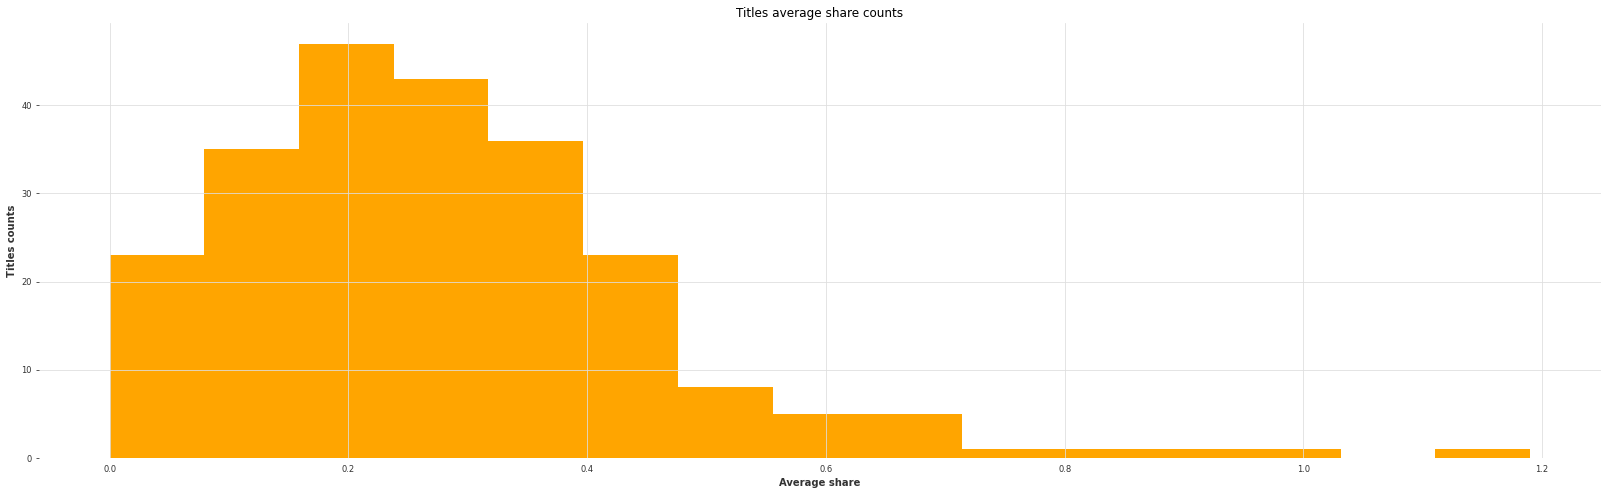

In [285]:
fig4, bx4 = plt.subplots(figsize=(28, 8)) 
bx4.hist(History_title_avg_shr, bins= 15, color='orange')
bx4.set_xlabel('Average share') 
bx4.set_ylabel('Titles counts') 
bx4.set_title('Titles average share counts') 

plt.show()

# 5. Tworzenie ramki danych do modelowania szeregów czasowych ze wspołzmiennymi. 

In [48]:
History_agg = History[['Date_time', 'Share', 'Title']]
df_agg = History_agg.groupby([pd.Grouper(key='Date_time', freq='3H'), 'Title'])['Share'].mean().reset_index()
df_agg

Date_time                       Title  Share
0     2017-12-22 00:00:00                  Ludzie gor  0.000
1     2017-12-22 00:00:00              Wykute w ogniu  0.000
2     2017-12-22 03:00:00     Auto-reanimacja detroit  0.000
3     2017-12-22 03:00:00            Gwiazdy lombardu  0.000
4     2017-12-22 03:00:00              Poznaj history  0.000
...                   ...                         ...    ...
39987 2022-12-21 21:00:00          Starozytni kosmici  0.455
39988 2022-12-21 21:00:00  Tajemnice skryte w dzungli  0.306
39989 2022-12-22 00:00:00             Jak to wyjasnic  0.212
39990 2022-12-22 00:00:00                  Ludzie gor  1.248
39991 2022-12-22 00:00:00          Starozytni kosmici  0.081

[39992 rows x 3 columns]

In [49]:
time_index = pd.date_range(start=df_agg['Date_time'].min(), end=df_agg['Date_time'].max(), freq='3H')
time_df = pd.DataFrame(index=time_index)
time_df

Empty DataFrame
Columns: []
Index: [2017-12-22 00:00:00, 2017-12-22 03:00:00, 2017-12-22 06:00:00, 2017-12-22 09:00:00, 2017-12-22 12:00:00, 2017-12-22 15:00:00, 2017-12-22 18:00:00, 2017-12-22 21:00:00, 2017-12-23 00:00:00, 2017-12-23 03:00:00, 2017-12-23 06:00:00, 2017-12-23 09:00:00, 2017-12-23 12:00:00, 2017-12-23 15:00:00, 2017-12-23 18:00:00, 2017-12-23 21:00:00, 2017-12-24 00:00:00, 2017-12-24 03:00:00, 2017-12-24 06:00:00, 2017-12-24 09:00:00, 2017-12-24 12:00:00, 2017-12-24 15:00:00, 2017-12-24 18:00:00, 2017-12-24 21:00:00, 2017-12-25 00:00:00, 2017-12-25 03:00:00, 2017-12-25 06:00:00, 2017-12-25 09:00:00, 2017-12-25 12:00:00, 2017-12-25 15:00:00, 2017-12-25 18:00:00, 2017-12-25 21:00:00, 2017-12-26 00:00:00, 2017-12-26 03:00:00, 2017-12-26 06:00:00, 2017-12-26 09:00:00, 2017-12-26 12:00:00, 2017-12-26 15:00:00, 2017-12-26 18:00:00, 2017-12-26 21:00:00, 2017-12-27 00:00:00, 2017-12-27 03:00:00, 2017-12-27 06:00:00, 2017-12-27 09:00:00, 2017-12-27 12:00:00, 2017-12-27 15:00:00, 2017-12-27 18:00:00, 2017-12-27 21:00:00, 2017-12-28 00:00:00, 2017-12-28 03:00:00, 2017-12-28 06:00:00, 2017-12-28 09:00:00, 2017-12-28 12:00:00, 2017-12-28 15:00:00, 2017-12-28 18:00:00, 2017-12-28 21:00:00, 2017-12-29 00:00:00, 2017-12-29 03:00:00, 2017-12-29 06:00:00, 2017-12-29 09:00:00, 2017-12-29 12:00:00, 2017-12-29 15:00:00, 2017-12-29 18:00:00, 2017-12-29 21:00:00, 2017-12-30 00:00:00, 2017-12-30 03:00:00, 2017-12-30 06:00:00, 2017-12-30 09:00:00, 2017-12-30 12:00:00, 2017-12-30 15:00:00, 2017-12-30 18:00:00, 2017-12-30 21:00:00, 2017-12-31 00:00:00, 2017-12-31 03:00:00, 2017-12-31 06:00:00, 2017-12-31 09:00:00, 2017-12-31 12:00:00, 2017-12-31 15:00:00, 2017-12-31 18:00:00, 2017-12-31 21:00:00, 2018-01-01 00:00:00, 2018-01-01 03:00:00, 2018-01-01 06:00:00, 2018-01-01 09:00:00, 2018-01-01 12:00:00, 2018-01-01 15:00:00, 2018-01-01 18:00:00, 2018-01-01 21:00:00, 2018-01-02 00:00:00, 2018-01-02 03:00:00, 2018-01-02 06:00:00, 2018-01-02 09:00:00, 2018-01-02 12:00:00, 2018-01-02 15:00:00, 2018-01-02 18:00:00, 2018-01-02 21:00:00, 2018-01-03 00:00:00, 2018-01-03 03:00:00, 2018-01-03 06:00:00, 2018-01-03 09:00:00, ...]

[14609 rows x 0 columns]

In [50]:
df_agg.set_index('Date_time', inplace=True)
df_agg

Title  Share
Date_time                                             
2017-12-22 00:00:00                  Ludzie gor  0.000
2017-12-22 00:00:00              Wykute w ogniu  0.000
2017-12-22 03:00:00     Auto-reanimacja detroit  0.000
2017-12-22 03:00:00            Gwiazdy lombardu  0.000
2017-12-22 03:00:00              Poznaj history  0.000
...                                         ...    ...
2022-12-21 21:00:00          Starozytni kosmici  0.455
2022-12-21 21:00:00  Tajemnice skryte w dzungli  0.306
2022-12-22 00:00:00             Jak to wyjasnic  0.212
2022-12-22 00:00:00                  Ludzie gor  1.248
2022-12-22 00:00:00          Starozytni kosmici  0.081

[39992 rows x 2 columns]

In [51]:
program_df = pd.get_dummies(df_agg['Title'])
program_df

#liniaprosta  Ale bryka  Alone: przetrwac najdluzej  \
Date_time                                                                  
2017-12-22 00:00:00             0          0                           0   
2017-12-22 00:00:00             0          0                           0   
2017-12-22 03:00:00             0          0                           0   
2017-12-22 03:00:00             0          0                           0   
2017-12-22 03:00:00             0          0                           0   
...                           ...        ...                         ...   
2022-12-21 21:00:00             0          0                           0   
2022-12-21 21:00:00             0          0                           0   
2022-12-22 00:00:00             0          0                           0   
2022-12-22 00:00:00             0          0                           0   
2022-12-22 00:00:00             0          0                           0   

                     Amerykanscy naprawiacze  Amerykanscy zbieracze  \
Date_time                                                             
2017-12-22 00:00:00                        0                      0   
2017-12-22 00:00:00                        0                      0   
2017-12-22 03:00:00                        0                      0   
2017-12-22 03:00:00                        0                      0   
2017-12-22 03:00:00                        0                      0   
...                                      ...                    ...   
2022-12-21 21:00:00                        0                      0   
2022-12-21 21:00:00                        0                      0   
2022-12-22 00:00:00                        0                      0   
2022-12-22 00:00:00                        0                      0   
2022-12-22 00:00:00                        0                      0   

                     Amerykanska ksiega tajemnic  \
Date_time                                          
2017-12-22 00:00:00                            0   
2017-12-22 00:00:00                            0   
2017-12-22 03:00:00                            0   
2017-12-22 03:00:00                            0   
2017-12-22 03:00:00                            0   
...                                          ...   
2022-12-21 21:00:00                            0   
2022-12-21 21:00:00                            0   
2022-12-22 00:00:00                            0   
2022-12-22 00:00:00                            0   
2022-12-22 00:00:00                            0   

                     Amerykanski rozpruwacz w londynie  Atlantyda odnaleziona  \
Date_time                                                                       
2017-12-22 00:00:00                                  0                      0   
2017-12-22 00:00:00                                  0                      0   
2017-12-22 03:00:00                                  0                      0   
2017-12-22 03:00:00                                  0                      0   
2017-12-22 03:00:00                                  0                      0   
...                                                ...                    ...   
2022-12-21 21:00:00                                  0                      0   
2022-12-21 21:00:00                                  0                      0   
2022-12-22 00:00:00                                  0                      0   
2022-12-22 00:00:00                                  0                      0   
2022-12-22 00:00:00                                  0                      0   

                     Auschwitz podroz do piekla  Australijscy zbieracze  ...  \
Date_time                                                                ...   
2017-12-22 00:00:00                           0                       0  ...   
2017-12-22 00:00:00                           0                       0  ...   
2017-12-22 03:00:00                           0          

## 5.1 Stworzenie ramki danych z pozycjami heat'owymi dla kanałów o oglądalności powyżej 0.1 w trzygodzinnych pasmach programowych.

In [52]:
work_agg = work[['Date_time', 'Share', 'Title', 'Channel']]
work_agg = work_agg.groupby([pd.Grouper(key='Date_time', freq='3H'), 'Title', 'Channel'])['Share'].mean().reset_index()
work_agg1 = work_agg.drop(['Share'], axis = 1)
work_agg_merged = pd.merge(work_agg1, heat_titles, on='Title')

work_agg_merged = work_agg_merged.drop(['Share', 'Title'], axis = 1) 
work_agg_grouped = work_agg_merged.groupby([pd.Grouper(key='Date_time', freq='3H'), pd.Grouper(key='Channel')])['Heat'].mean().reset_index()
pivot_chdf = work_agg_grouped.pivot(index='Date_time', columns='Channel', values='Heat')

for i in channel_avg_shr.index:
    if (channel_avg_shr['Channel'][i] == "History") or (channel_avg_shr['Share'][i] < 0.1):
        name = channel_avg_shr['Channel'][i]
        pivot_chdf = pivot_chdf.drop(str(name), axis = 1)  
        
pivot_chdf

Channel              BBC Earth  Discovery Historia  Discovery Science  \
Date_time                                                               
2017-12-22 00:00:00        0.0            0.250000           0.250000   
2017-12-22 03:00:00        0.0            0.000000           0.750000   
2017-12-22 06:00:00        0.0            0.000000           0.428571   
2017-12-22 09:00:00        0.0            0.250000           0.600000   
2017-12-22 12:00:00        0.0            0.333333           0.500000   
...                        ...                 ...                ...   
2022-12-21 12:00:00        0.0            0.000000           0.500000   
2022-12-21 15:00:00        0.0            0.500000           1.000000   
2022-12-21 18:00:00        0.0            0.000000           0.000000   
2022-12-21 21:00:00        0.0            0.000000           0.000000   
2022-12-22 00:00:00        0.0            0.000000           0.500000   

Channel              Discovery pl  Fokus TV  History2 [H2]  \
Date_time                                                    
2017-12-22 00:00:00      0.666667      1.00       0.500000   
2017-12-22 03:00:00      0.833333      1.00       0.000000   
2017-12-22 06:00:00      0.750000      1.00       0.333333   
2017-12-22 09:00:00      1.000000      0.75       0.000000   
2017-12-22 12:00:00      1.000000      1.00       0.333333   
...                           ...       ...            ...   
2022-12-21 12:00:00      1.000000      1.00       0.250000   
2022-12-21 15:00:00      1.000000      1.00       0.333333   
2022-12-21 18:00:00      1.000000      1.00       0.000000   
2022-12-21 21:00:00      1.000000      1.00       0.000000   
2022-12-22 00:00:00      1.000000      1.00       0.500000   

Channel              National Geographic  Polsat Play  Polsat Viasat Explore  \
Date_time                                                                      
2017-12-22 00:00:00             1.000000     1.000000                    0.0   
2017-12-22 03:00:00             1.000000     0.800000                    0.0   
2017-12-22 06:00:00             1.000000     0.833333                    0.0   
2017-12-22 09:00:00             0.666667     1.000000                    0.0   
2017-12-22 12:00:00             1.000000     0.750000                    0.0   
...                                  ...          ...                    ...   
2022-12-21 12:00:00             1.000000     1.000000                    0.0   
2022-12-21 15:00:00             1.000000     1.000000                    0.0   
2022-12-21 18:00:00             0.750000     1.000000                    0.0   
2022-12-21 21:00:00             0.500000     1.000000                    0.0   
2022-12-22 00:00:00             1.000000     1.000000                    0.0   

Channel              Polsat Viasat History  TVN Turbo    WP   Zoom TV  
Date_time                                                              
2017-12-22 00:00:00               0.000000        1.0  1.00  0.666667  
2017-12-22 03:00:00               0.571429        0.8  1.00  0.400000  
2017-12-22 06:00:00               0.000000        0.8  1.00  0.000000  
2017-12-22 09:00:00               0.000000        1.0  0.75  0.333333  
2017-12-22 12:00:00               0.000000        1.0  1.00  0.600000  
...                                    ...        ...   ...       ...  
2022-12-21 12:00:00               0.500000        1.0  1.00  1.000000  
2022-12-21 15:00:00               0.500000        1.0  0.75  1.000000  
2022-12-21 18:00:00               0.000000        1.0  1.00  1.000000  
2022-12-21 21:00:00               0.000000        1.0  1.00  1.000000  
2022-12-22 00:00:00               0.000000        1.0  1.00  1.000000  

[14609 rows x 13 columns]

In [53]:
pivot_chdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14609 entries, 2017-12-22 00:00:00 to 2022-12-22 00:00:00
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BBC Earth              14609 non-null  float64
 1   Discovery Historia     14603 non-null  float64
 2   Discovery Science      14603 non-null  float64
 3   Discovery pl           14603 non-null  float64
 4   Fokus TV               14580 non-null  float64
 5   History2 [H2]          14609 non-null  float64
 6   National Geographic    14609 non-null  float64
 7   Polsat Play            14567 non-null  float64
 8   Polsat Viasat Explore  14609 non-null  float64
 9   Polsat Viasat History  14609 non-null  float64
 10  TVN Turbo              14603 non-null  float64
 11  WP                     14605 non-null  float64
 12  Zoom TV                14604 non-null  float64
dtypes: float64(13)
memory usage: 1.6 MB


In [54]:
History_granulated = History[['Date_time', 'Share', 'Audience']]

In [55]:
History_granulated.set_index('Date_time', inplace=True)
History_granulated = History_granulated.resample('3H').mean()
History_granulated

Share   Audience
Date_time                               
2017-12-22 00:00:00  0.000000   0.000000
2017-12-22 03:00:00  0.083167   0.539000
2017-12-22 06:00:00  0.083750   0.859000
2017-12-22 09:00:00  0.483000  13.179200
2017-12-22 12:00:00  1.361667  41.608833
...                       ...        ...
2022-12-21 12:00:00  0.523857  13.609429
2022-12-21 15:00:00  0.744250  26.405750
2022-12-21 18:00:00  0.199333  11.880333
2022-12-21 21:00:00  0.366250  16.568750
2022-12-22 00:00:00  0.513667   5.893667

[14609 rows x 2 columns]

In [56]:
History_granulated['Share'].fillna(0, inplace=True)
History_granulated['Audience'].fillna(0, inplace=True)

In [57]:
History_granulated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14609 entries, 2017-12-22 00:00:00 to 2022-12-22 00:00:00
Freq: 3H
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Share     14609 non-null  float64
 1   Audience  14609 non-null  float64
dtypes: float64(2)
memory usage: 342.4 KB


In [58]:
result = pd.merge(time_df, program_df, left_index=True, right_on='Date_time', how='left') 
result = result.fillna(0).set_index('Date_time')
result = result.groupby(level=0).sum()
result

#liniaprosta  Ale bryka  Alone: przetrwac najdluzej  \
Date_time                                                                  
2017-12-22 00:00:00           0.0        0.0                         0.0   
2017-12-22 03:00:00           0.0        0.0                         0.0   
2017-12-22 06:00:00           0.0        0.0                         1.0   
2017-12-22 09:00:00           0.0        0.0                         0.0   
2017-12-22 12:00:00           0.0        0.0                         0.0   
...                           ...        ...                         ...   
2022-12-21 12:00:00           0.0        0.0                         0.0   
2022-12-21 15:00:00           0.0        0.0                         0.0   
2022-12-21 18:00:00           0.0        0.0                         0.0   
2022-12-21 21:00:00           0.0        0.0                         0.0   
2022-12-22 00:00:00           0.0        0.0                         0.0   

                     Amerykanscy naprawiacze  Amerykanscy zbieracze  \
Date_time                                                             
2017-12-22 00:00:00                      0.0                    0.0   
2017-12-22 03:00:00                      0.0                    0.0   
2017-12-22 06:00:00                      0.0                    0.0   
2017-12-22 09:00:00                      0.0                    0.0   
2017-12-22 12:00:00                      0.0                    0.0   
...                                      ...                    ...   
2022-12-21 12:00:00                      0.0                    0.0   
2022-12-21 15:00:00                      0.0                    0.0   
2022-12-21 18:00:00                      0.0                    0.0   
2022-12-21 21:00:00                      0.0                    0.0   
2022-12-22 00:00:00                      0.0                    0.0   

                     Amerykanska ksiega tajemnic  \
Date_time                                          
2017-12-22 00:00:00                          0.0   
2017-12-22 03:00:00                          0.0   
2017-12-22 06:00:00                          0.0   
2017-12-22 09:00:00                          0.0   
2017-12-22 12:00:00                          0.0   
...                                          ...   
2022-12-21 12:00:00                          0.0   
2022-12-21 15:00:00                          0.0   
2022-12-21 18:00:00                          0.0   
2022-12-21 21:00:00                          0.0   
2022-12-22 00:00:00                          0.0   

                     Amerykanski rozpruwacz w londynie  Atlantyda odnaleziona  \
Date_time                                                                       
2017-12-22 00:00:00                                0.0                    0.0   
2017-12-22 03:00:00                                0.0                    0.0   
2017-12-22 06:00:00                                0.0                    0.0   
2017-12-22 09:00:00                                0.0                    0.0   
2017-12-22 12:00:00                                0.0                    0.0   
...                                                ...                    ...   
2022-12-21 12:00:00                                0.0                    0.0   
2022-12-21 15:00:00                                0.0                    0.0   
2022-12-21 18:00:00                                0.0                    0.0   
2022-12-21 21:00:00                                0.0                    0.0   
2022-12-22 00:00:00                                0.0                    0.0   

                     Auschwitz podroz do piekla  Australijscy zbieracze  ...  \
Date_time                                                                ...   
2017-12-22 00:00:00                         0.0                     0.0  ...   
2017-12-22 03:00:00                         0.0                     0.0  ...   
2017-12-22 06:00:00                         0.0          

## 5.2 Łączenie średniej oglądalności i widowni programu History z tabelami przedstawiającymi, które tytuły były grane w danym paśmie i ze średnim pokryciem pozycjami heat'owymi w stacjach konkurencyjnych.

In [59]:
ShareOHEtemp = pd.merge(History_granulated, result, left_index=True, right_on='Date_time', how='left') 
ShareOHE = pd.merge(ShareOHEtemp, pivot_chdf, left_index = True, right_on='Date_time')
ShareOHE = ShareOHE.fillna(0)
ShareOHE.tail(60) 

Share   Audience  #liniaprosta  Ale bryka  \
Date_time                                                           
2022-12-14 15:00:00  0.543000  21.272250           0.0        0.0   
2022-12-14 18:00:00  0.629667  37.457000           0.0        0.0   
2022-12-14 21:00:00  0.205750   6.754500           0.0        0.0   
2022-12-15 00:00:00  0.144400   2.417400           0.0        0.0   
2022-12-15 03:00:00  0.010250   0.047250           0.0        0.0   
2022-12-15 06:00:00  0.131667   2.519167           0.0        0.0   
2022-12-15 09:00:00  0.241667   5.559667           0.0        0.0   
2022-12-15 12:00:00  0.548714  13.815857           0.0        0.0   
2022-12-15 15:00:00  0.291250  11.399250           0.0        0.0   
2022-12-15 18:00:00  0.191333  11.551333           0.0        0.0   
2022-12-15 21:00:00  0.153000   5.465000           0.0        0.0   
2022-12-16 00:00:00  0.125600   1.119200           0.0        0.0   
2022-12-16 03:00:00  0.169000   0.997250           0.0        0.0   
2022-12-16 06:00:00  0.197000   2.477833           0.0        0.0   
2022-12-16 09:00:00  0.508667  11.551167           0.0        0.0   
2022-12-16 12:00:00  0.278000   7.380714           0.0        0.0   
2022-12-16 15:00:00  0.384750  14.283250           0.0        0.0   
2022-12-16 18:00:00  0.331333  19.037667           0.0        0.0   
2022-12-16 21:00:00  0.179250   7.866000           0.0        0.0   
2022-12-17 00:00:00  0.281000   4.419000           0.0        0.0   
2022-12-17 03:00:00  0.984167   4.528833           0.0        0.0   
2022-12-17 06:00:00  0.907800   7.926800           0.0        0.0   
2022-12-17 09:00:00  0.119286   3.884714           0.0        0.0   
2022-12-17 12:00:00  0.301625  11.627000           0.0        0.0   
2022-12-17 15:00:00  0.122333   6.837333           0.0        0.0   
2022-12-17 18:00:00  0.114333   7.166333           0.0        0.0   
2022-12-17 21:00:00  0.109500   4.158500           0.0        0.0   
2022-12-18 00:00:00  1.099000  13.705500           0.0        0.0   
2022-12-18 03:00:00  0.379600   1.599600           0.0        0.0   
2022-12-18 06:00:00  0.084200   1.475000           0.0        0.0   
2022-12-18 09:00:00  0.227667   9.744667           0.0        0.0   
2022-12-18 12:00:00  0.164000   7.983500           0.0        0.0   
2022-12-18 15:00:00  0.187000  13.259333           0.0        0.0   
2022-12-18 18:00:00  0.157250  12.743500           0.0        0.0   
2022-12-18 21:00:00  0.198750   8.042000           0.0        0.0   
2022-12-19 00:00:00  0.205750   1.867500           0.0        0.0   
2022-12-19 03:00:00  0.555333   2.890000           0.0        0.0   
2022-12-19 06:00:00  0.195333   3.124333           0.0        0.0   
2022-12-19 09:00:00  0.610500  13.616000           0.0        0.0   
2022-12-19 12:00:00  0.970571  24.233571           0.0        0.0   
2022-12-19 15:00:00  0.665750  25.171000           0.0        0.0   
2022-12-19 18:00:00  0.138000   8.418333           0.0        0.0   
2022-12-19 21:00:00  0.303000  14.754000           0.0        0.0   
2022-12-20 00:00:00  0.152000   1.484400           0.0        0.0   
2022-12-20 03:00:00  0.038000   0.231250           0.0        0.0   
2022-12-20 06:00:00  0.043000   0.822333           0.0        0.0   
2022-12-20 09:00:00  0.525333  11.786333           0.0        0.0   
2022-12-20 12:00:00  0.751571  18.820857           0.0        0.0   
2022-12-20 15:00:00  0.230000   7.818250           0.0        0.0   
2022-12-20 18:00:00  0.174667  10.428333           0.0        0.0   
2022-12-20 21:00:00  0.147750   6.036250           0.0        0.0   
2022-12-21 00:00:00  1.124800   9.992600           0.0        0.0   
2022-12-21 03:00:00  0.272750   1.094000           0.0        0.0   
2022-12-21 06:00:00  0.650500  10.044667           0.0        0.0   
2022-12-21 09:00:00  0.143833   3.211167           0.0        0.0   
2022-12-21 12:00:00  0.523857  13.609429           0.0        0.0   
2022-12-21 15:00:00  0

In [60]:
ShareOHE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14609 entries, 2017-12-22 00:00:00 to 2022-12-22 00:00:00
Columns: 245 entries, Share to Zoom TV
dtypes: float64(245)
memory usage: 27.4 MB


# 6. Modelowanie szeregu czasowego

In [62]:
test = ShareOHE['2022-10-21':] 
train = ShareOHE[:'2022-10-20']

<AxesSubplot:xlabel='Date_time'>

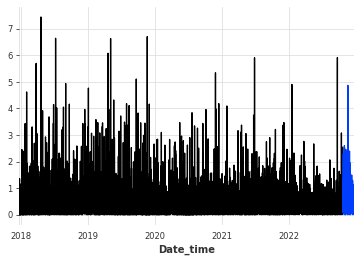

In [63]:
train['Share'].plot(label='train')
test['Share'].plot(label='test')

<AxesSubplot:xlabel='Date_time'>

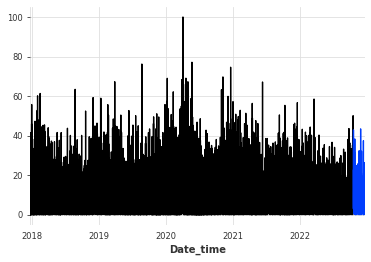

In [64]:
train['Audience'].plot(label='train')
test['Audience'].plot(label='test')

In [65]:
featuresdf = ShareOHE.drop(['Share', 'Audience'], axis = 1) #zrobić listę kolumn

features = list(featuresdf.columns)
target = ['Share', 'Audience']

In [66]:
target_ts_test = darts.TimeSeries.from_dataframe(test[target])
feature_ts_test = darts.TimeSeries.from_dataframe(ShareOHE[features])
target_ts_train = darts.TimeSeries.from_dataframe(train[target])
feature_ts_train = darts.TimeSeries.from_dataframe(train[features])

## 6.2 Model darts LightGBM z wykorzystaniem tylko przeszłych współzmiennych (past covariates).

In [169]:
model = LightGBMModel(
        lags=56,
        lags_past_covariates=8,
        lags_future_covariates=None, 
        output_chunk_length=len(target_ts_test),
        add_encoders=None,
        likelihood=None,
        quantiles=None,
        random_state=None,
        )
# lags 56 => tydzień

In [170]:
model.fit(target_ts_train, feature_ts_train)
#fit(series, past_covariates=None, future_covariates=None, val_series=None, val_past_covariates=None, val_future_covariates=None, max_samples_per_ts=None, **kwargs)

C:\Users\asus\anaconda3\lib\site-packages\darts\timeseries.py:4039: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [203]:
# zapis modelu

In [218]:
#with open('model_pst_cov.pkl', 'wb') as f1:
 #   pickle.dump(model, f1)

In [79]:
with open('model_pst_cov.pkl', 'rb') as f1:
    model = pickle.load(f1)

In [80]:
predykcja = model.predict(len(target_ts_test), target_ts_train, feature_ts_train)

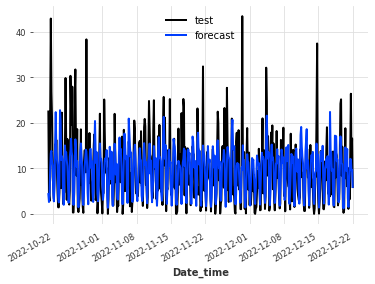

In [82]:
target_ts_test['Audience'].plot(label='test')
predykcja['Audience'].plot(label='forecast')

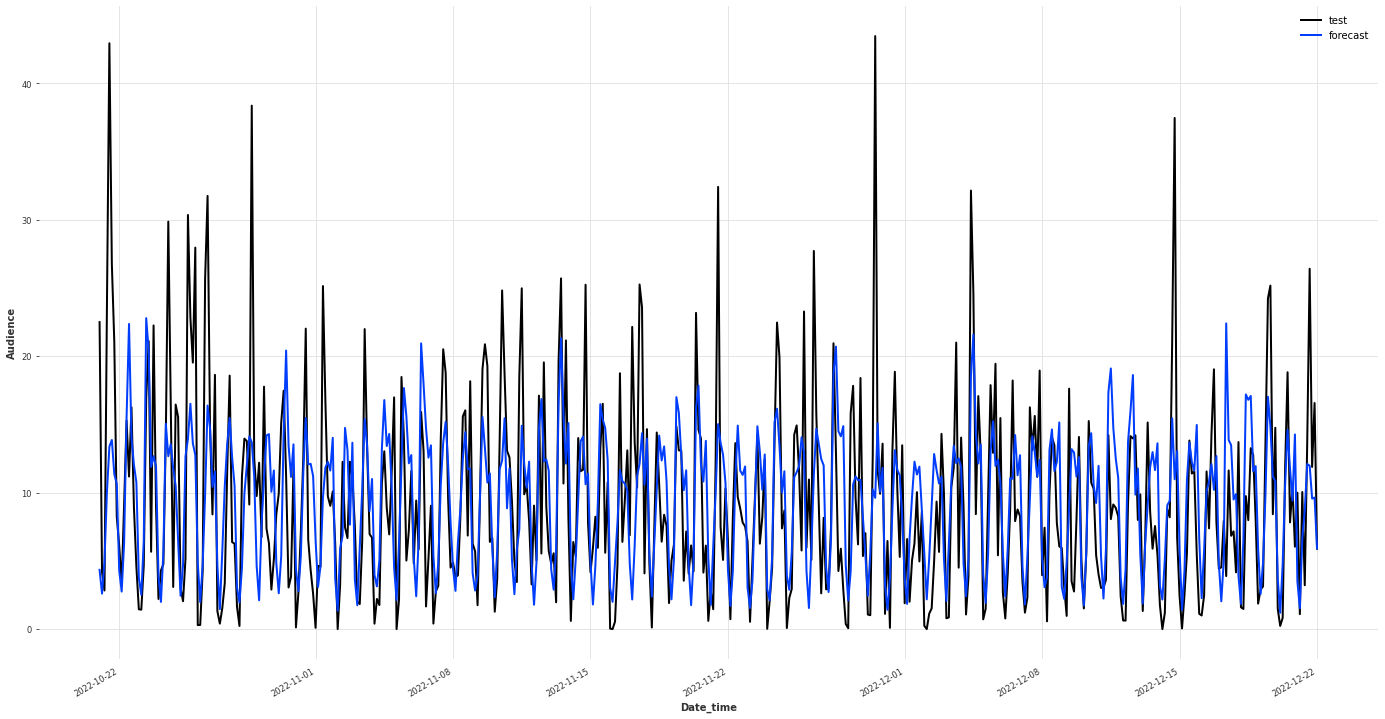

In [331]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'].plot(ax=ax, label='test')
predykcja['Audience'].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

### 6.2.1 Metryki

In [87]:
darts.metrics.metrics.mae(target_ts_test["Audience"], predykcja["Audience"], intersect=True) 

4.4613375283146635

In [89]:
darts.metrics.metrics.mse(target_ts_test["Audience"], predykcja["Audience"], intersect=True) 

37.088355548405225

In [91]:
darts.metrics.r2_score(target_ts_test["Audience"], predykcja["Audience"]) 

0.3062154075706338

In [93]:
darts.metrics.metrics.rmse(target_ts_test["Audience"], predykcja["Audience"], intersect=True)

6.090020980949509

In [95]:
# wkleić kawałek tabeli z faktycznymi wynikami oglądalności i w osobnej kolumnie prognozowanymi

In [96]:
predykcjadf = predykcja.pd_dataframe()
target_ts_testdf = target_ts_test.pd_dataframe()

In [97]:
Compare = pd.merge(target_ts_testdf['Audience'], predykcjadf['Audience'], left_index=True, right_on='Date_time', how='left')
Compare.tail(60)

Audience_x  Audience_y
Date_time                                  
2022-12-14 15:00:00   21.272250   15.446896
2022-12-14 18:00:00   37.457000   10.976554
2022-12-14 21:00:00    6.754500   13.051845
2022-12-15 00:00:00    2.417400    5.784466
2022-12-15 03:00:00    0.047250    1.397915
2022-12-15 06:00:00    2.519167    4.277814
2022-12-15 09:00:00    5.559667   10.949290
2022-12-15 12:00:00   13.815857   13.675650
2022-12-15 15:00:00   11.399250   12.228228
2022-12-15 18:00:00   11.551333   11.606769
2022-12-15 21:00:00    5.465000   14.959764
2022-12-16 00:00:00    1.119200    6.634014
2022-12-16 03:00:00    0.997250    2.266013
2022-12-16 06:00:00    2.477833    5.819576
2022-12-16 09:00:00   11.551167   10.092842
2022-12-16 12:00:00    7.380714   10.828088
2022-12-16 15:00:00   14.283250   12.097560
2022-12-16 18:00:00   19.037667   10.202917
2022-12-16 21:00:00    7.866000   12.683368
2022-12-17 00:00:00    4.419000    4.788756
2022-12-17 03:00:00    4.528833    2.035750
2022-12-17 06:00:00    7.926800    5.077630
2022-12-17 09:00:00    3.884714   22.400827
2022-12-17 12:00:00   11.627000   13.856133
2022-12-17 15:00:00    6.837333   13.485722
2022-12-17 18:00:00    7.166333    9.494629
2022-12-17 21:00:00    4.158500    9.893388
2022-12-18 00:00:00   13.705500    3.887870
2022-12-18 03:00:00    1.599600    1.839280
2022-12-18 06:00:00    1.475000    6.513982
2022-12-18 09:00:00    9.744667   17.196014
2022-12-18 12:00:00    7.983500   16.801294
2022-12-18 15:00:00   13.259333   17.083275
2022-12-18 18:00:00   12.743500   11.571153
2022-12-18 21:00:00    8.042000   11.944030
2022-12-19 00:00:00    1.867500    5.879574
2022-12-19 03:00:00    2.890000    2.563424
2022-12-19 06:00:00    3.124333    4.833632
2022-12-19 09:00:00   13.616000    9.834055
2022-12-19 12:00:00   24.233571   17.026220
2022-12-19 15:00:00   25.171000   14.862140
2022-12-19 18:00:00    8.418333   11.182834
2022-12-19 21:00:00   14.754000   10.849885
2022-12-20 00:00:00    1.484400    3.692412
2022-12-20 03:00:00    0.231250    1.193771
2022-12-20 06:00:00    0.822333    4.735532
2022-12-20 09:00:00   11.786333   10.557714
2022-12-20 12:00:00   18.820857   14.604687
2022-12-20 15:00:00    7.818250   11.754299
2022-12-20 18:00:00   10.428333    9.411337
2022-12-20 21:00:00    6.036250   14.262330
2022-12-21 00:00:00    9.992600    3.494557
2022-12-21 03:00:00    1.094000    1.528656
2022-12-21 06:00:00   10.044667    6.637582
2022-12-21 09:00:00    3.211167    8.698713
2022-12-21 12:00:00   13.609429   12.095383
2022-12-21 15:00:00   26.405750   11.970870
2022-12-21 18:00:00   11.880333    9.563828
2022-12-21 21:00:00   16.568750    9.638255
2022-12-22 00:00:00    5.893667    5.916497

## 6.3 Model darts LightGBM z wykorzystaniem przyszłych współzmiennych (future covariates).

In [188]:
model2 = LightGBMModel(
        lags=224,
        lags_past_covariates=24,
        lags_future_covariates=(24,10), 
        output_chunk_length=len(target_ts_test),
        add_encoders=None,
        likelihood=None,
        quantiles=None,
        random_state=None,
        )

In [189]:
model2.fit(target_ts_train, feature_ts_train, feature_ts_test)

C:\Users\asus\anaconda3\lib\site-packages\darts\timeseries.py:4039: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [219]:
#with open('model2_fut_cov.pkl', 'wb') as f2:
#    pickle.dump(model2, f2)

In [99]:
with open('model2_fut_cov.pkl', 'rb') as f2:
    model2 = pickle.load(f2)

In [100]:
predykcja2 = model2.predict(len(target_ts_test), target_ts_train, feature_ts_train, feature_ts_test)

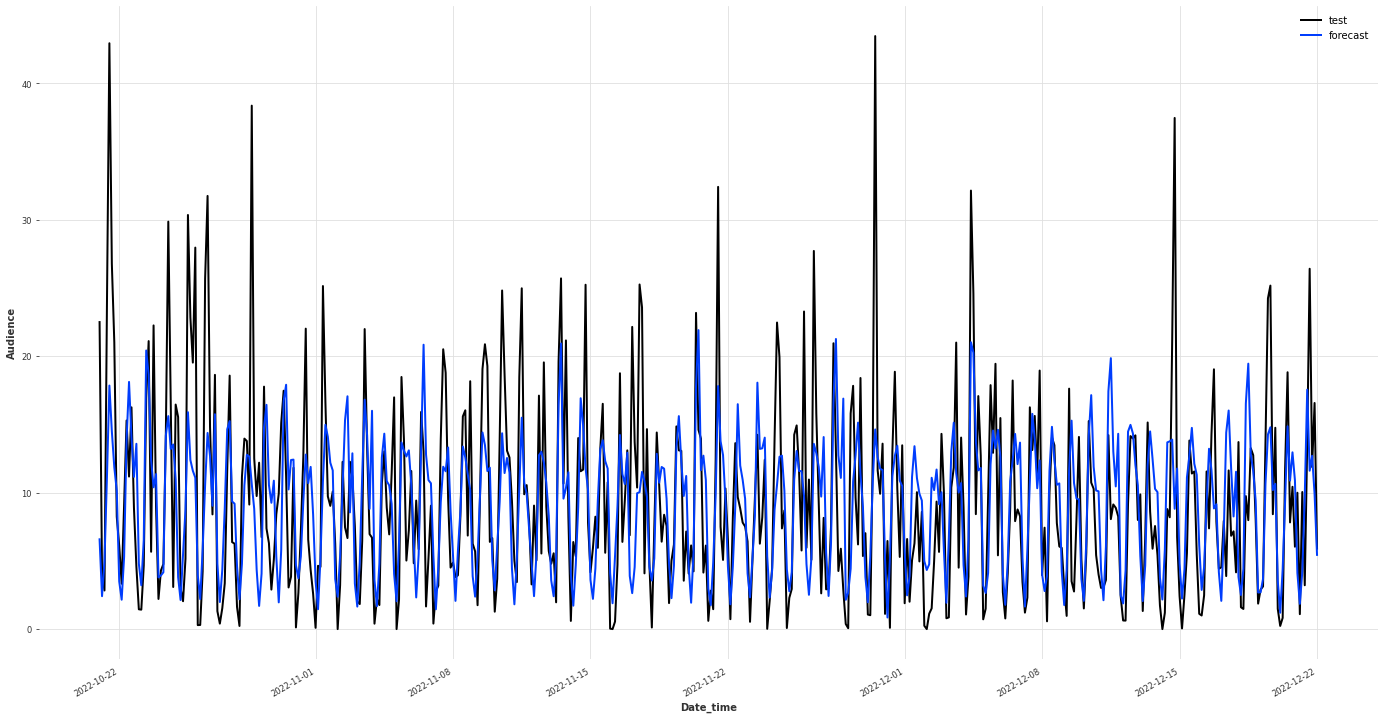

In [333]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'].plot(ax=ax, label='test')
predykcja2['Audience'].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

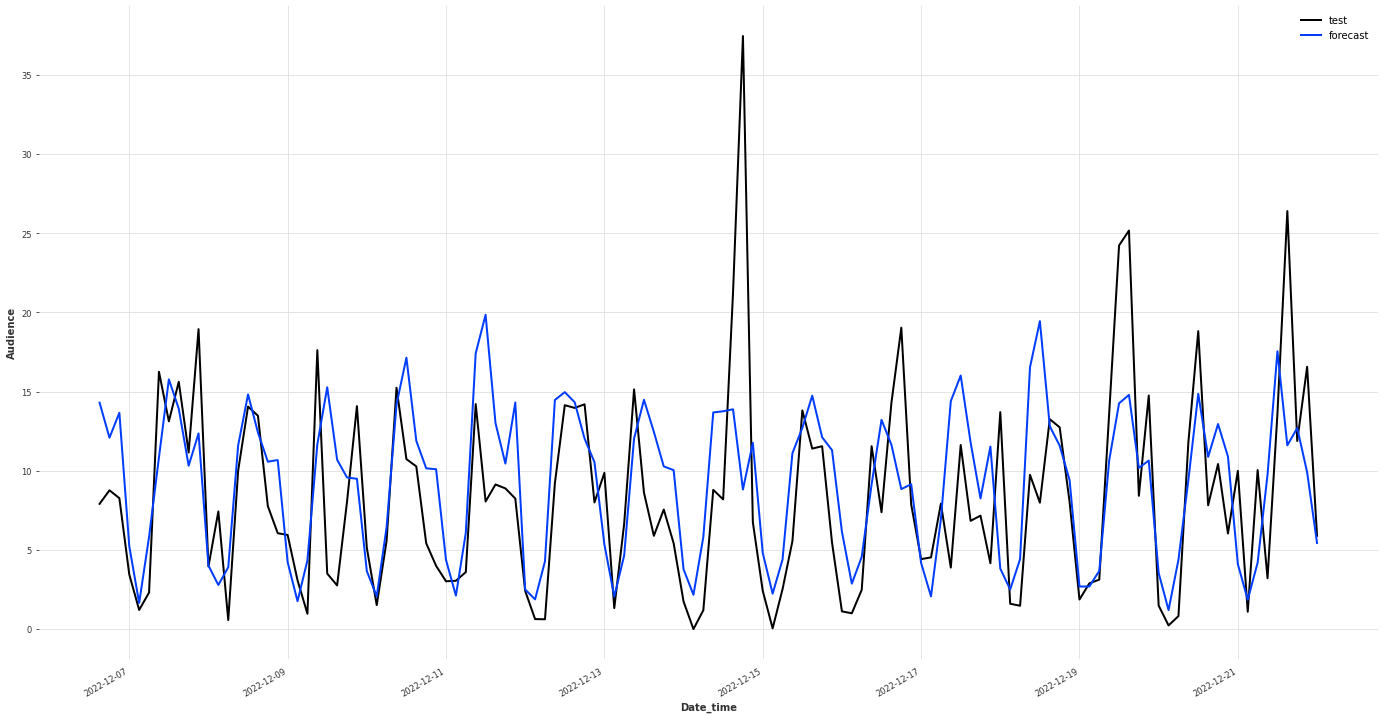

In [324]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][-124:].plot(ax=ax, label='test')
predykcja2['Audience'][-124:].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

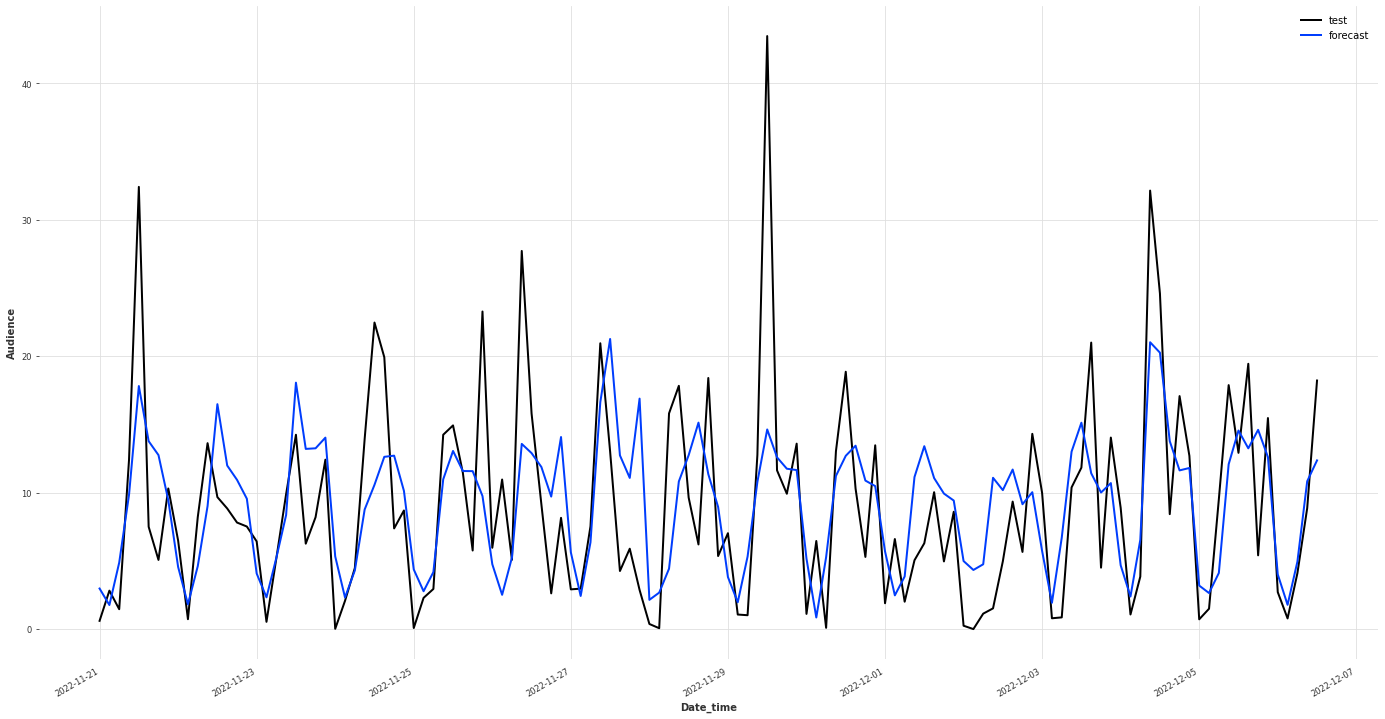

In [325]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][248:-124].plot(ax=ax, label='test')
predykcja2['Audience'][248:-124].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

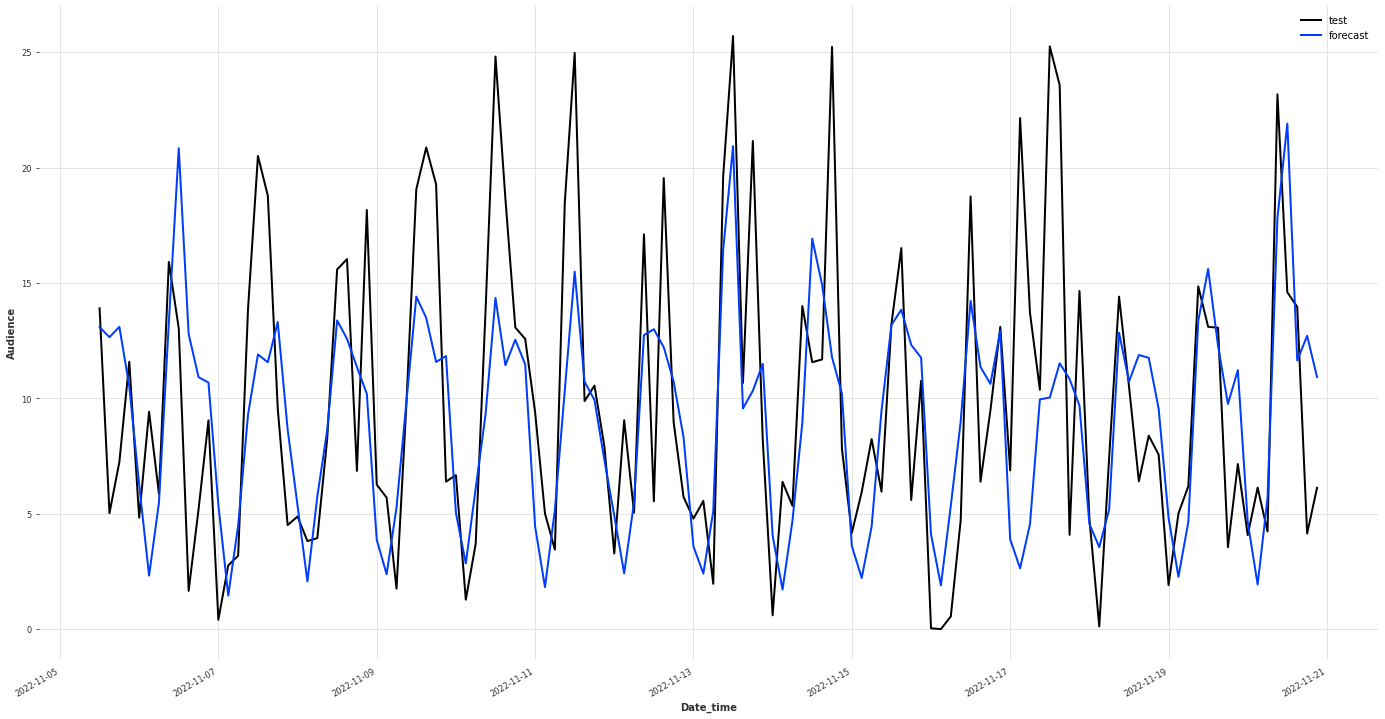

In [326]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][124:248].plot(ax=ax, label='test')
predykcja2['Audience'][124:248].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

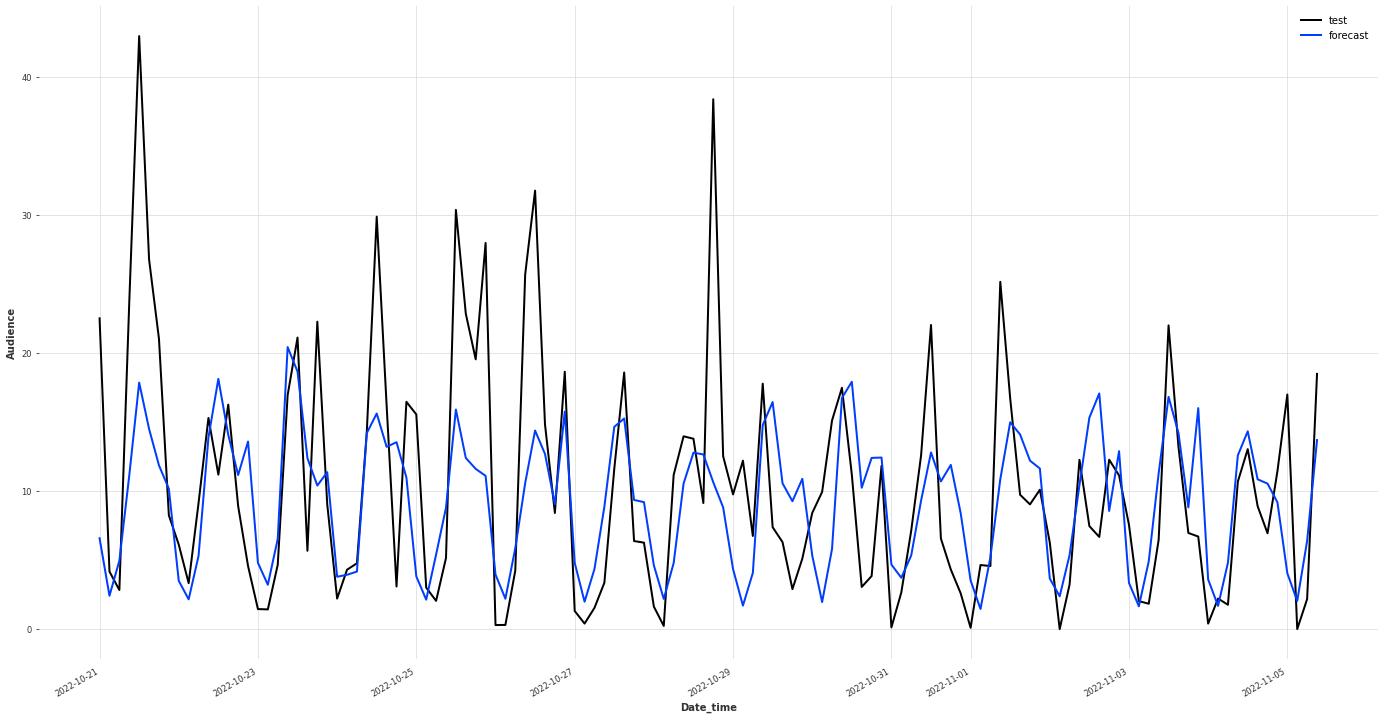

In [327]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][:124].plot(ax=ax, label='test')
predykcja2['Audience'][:124].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

### 6.3.1 Metryki

In [113]:
darts.metrics.metrics.mae(target_ts_test["Audience"], predykcja2["Audience"], intersect=True) # weryfikacja poprawności predykcji trendu (im mniej tym lepiej)

4.354806458422829

In [115]:
darts.metrics.metrics.mse(target_ts_test["Audience"], predykcja2["Audience"], intersect=True) # weryfikacja poprawności predykcji trendu

34.87292264316504

In [117]:
darts.metrics.r2_score(target_ts_test["Audience"], predykcja2["Audience"]) # weryfikacja poprawności predykcji trendu (im bliżej 1.0 tym lepiej)

0.3476578816973347

In [119]:
darts.metrics.metrics.rmse(target_ts_test["Audience"], predykcja2["Audience"], intersect=True) # Root Mean Squared Error

5.905330019835051

In [122]:
darts.metrics.r2_score(predykcja["Audience"], predykcja2["Audience"])

0.8452892595136903

In [124]:
darts.metrics.metrics.mae(predykcja["Audience"], predykcja2["Audience"], intersect=True)

1.4042493006584724

In [127]:
predykcja2df = predykcja2.pd_dataframe()
target_ts_testdf = target_ts_test.pd_dataframe()

In [128]:
Compare2 = pd.merge(target_ts_testdf['Audience'], predykcja2df['Audience'], left_index=True, right_on='Date_time', how='left')
Compare2.tail(60)

Audience_x  Audience_y
Date_time                                  
2022-12-14 15:00:00   21.272250   13.883846
2022-12-14 18:00:00   37.457000    8.816573
2022-12-14 21:00:00    6.754500   11.767383
2022-12-15 00:00:00    2.417400    4.812949
2022-12-15 03:00:00    0.047250    2.235321
2022-12-15 06:00:00    2.519167    4.395561
2022-12-15 09:00:00    5.559667   11.111148
2022-12-15 12:00:00   13.815857   12.707676
2022-12-15 15:00:00   11.399250   14.745050
2022-12-15 18:00:00   11.551333   12.117145
2022-12-15 21:00:00    5.465000   11.302454
2022-12-16 00:00:00    1.119200    6.153592
2022-12-16 03:00:00    0.997250    2.869308
2022-12-16 06:00:00    2.477833    4.562966
2022-12-16 09:00:00   11.551167    9.145794
2022-12-16 12:00:00    7.380714   13.214374
2022-12-16 15:00:00   14.283250   11.646858
2022-12-16 18:00:00   19.037667    8.840865
2022-12-16 21:00:00    7.866000    9.149594
2022-12-17 00:00:00    4.419000    4.180172
2022-12-17 03:00:00    4.528833    2.067740
2022-12-17 06:00:00    7.926800    6.954965
2022-12-17 09:00:00    3.884714   14.396989
2022-12-17 12:00:00   11.627000   16.016609
2022-12-17 15:00:00    6.837333   11.795160
2022-12-17 18:00:00    7.166333    8.253486
2022-12-17 21:00:00    4.158500   11.529590
2022-12-18 00:00:00   13.705500    3.819796
2022-12-18 03:00:00    1.599600    2.499937
2022-12-18 06:00:00    1.475000    4.425043
2022-12-18 09:00:00    9.744667   16.535426
2022-12-18 12:00:00    7.983500   19.450802
2022-12-18 15:00:00   13.259333   12.814675
2022-12-18 18:00:00   12.743500   11.586542
2022-12-18 21:00:00    8.042000    9.408608
2022-12-19 00:00:00    1.867500    2.687832
2022-12-19 03:00:00    2.890000    2.691993
2022-12-19 06:00:00    3.124333    3.677757
2022-12-19 09:00:00   13.616000   10.645267
2022-12-19 12:00:00   24.233571   14.261109
2022-12-19 15:00:00   25.171000   14.791900
2022-12-19 18:00:00    8.418333   10.183902
2022-12-19 21:00:00   14.754000   10.644147
2022-12-20 00:00:00    1.484400    3.543447
2022-12-20 03:00:00    0.231250    1.199767
2022-12-20 06:00:00    0.822333    4.382541
2022-12-20 09:00:00   11.786333    9.410678
2022-12-20 12:00:00   18.820857   14.860629
2022-12-20 15:00:00    7.818250   10.876825
2022-12-20 18:00:00   10.428333   12.952683
2022-12-20 21:00:00    6.036250   10.903293
2022-12-21 00:00:00    9.992600    4.106118
2022-12-21 03:00:00    1.094000    1.852340
2022-12-21 06:00:00   10.044667    4.198154
2022-12-21 09:00:00    3.211167    9.756749
2022-12-21 12:00:00   13.609429   17.545648
2022-12-21 15:00:00   26.405750   11.605749
2022-12-21 18:00:00   11.880333   12.698607
2022-12-21 21:00:00   16.568750    9.906404
2022-12-22 00:00:00    5.893667    5.438367

In [129]:
Compare2.head(60)

Audience_x  Audience_y
Date_time                                  
2022-10-21 00:00:00   22.497600    6.578962
2022-10-21 03:00:00    4.165500    2.411158
2022-10-21 06:00:00    2.827667    4.951435
2022-10-21 09:00:00   23.670167   11.122972
2022-10-21 12:00:00   42.930714   17.846102
2022-10-21 15:00:00   26.768250   14.495430
2022-10-21 18:00:00   21.017667   11.853923
2022-10-21 21:00:00    8.236250   10.154472
2022-10-22 00:00:00    6.115200    3.495582
2022-10-22 03:00:00    3.325750    2.153462
2022-10-22 06:00:00    9.128600    5.299115
2022-10-22 09:00:00   15.286667   13.880580
2022-10-22 12:00:00   11.177286   18.113552
2022-10-22 15:00:00   16.250750   14.060911
2022-10-22 18:00:00    8.910667   11.154516
2022-10-22 21:00:00    4.567667   13.579316
2022-10-23 00:00:00    1.450000    4.796421
2022-10-23 03:00:00    1.424800    3.210697
2022-10-23 06:00:00    4.655000    6.527127
2022-10-23 09:00:00   16.935000   20.417028
2022-10-23 12:00:00   21.104600   18.644642
2022-10-23 15:00:00    5.667333   12.377981
2022-10-23 18:00:00   22.253000   10.390696
2022-10-23 21:00:00    9.043250   11.358614
2022-10-24 00:00:00    2.207750    3.789730
2022-10-24 03:00:00    4.296333    3.930510
2022-10-24 06:00:00    4.764000    4.164865
2022-10-24 09:00:00   14.300167   14.191240
2022-10-24 12:00:00   29.858857   15.606195
2022-10-24 15:00:00   16.200250   13.193949
2022-10-24 18:00:00    3.084667   13.529369
2022-10-24 21:00:00   16.453500   10.972504
2022-10-25 00:00:00   15.541000    3.812802
2022-10-25 03:00:00    3.000750    2.130084
2022-10-25 06:00:00    2.043167    5.398361
2022-10-25 09:00:00    5.150167    8.785095
2022-10-25 12:00:00   30.346429   15.894498
2022-10-25 15:00:00   22.833500   12.389926
2022-10-25 18:00:00   19.528000   11.597486
2022-10-25 21:00:00   27.955500   11.094284
2022-10-26 00:00:00    0.292000    3.951129
2022-10-26 03:00:00    0.302000    2.196523
2022-10-26 06:00:00    4.237833    5.860232
2022-10-26 09:00:00   25.682000   10.567462
2022-10-26 12:00:00   31.741429   14.372916
2022-10-26 15:00:00   14.825250   12.679296
2022-10-26 18:00:00    8.404667    9.039912
2022-10-26 21:00:00   18.631250   15.744884
2022-10-27 00:00:00    1.312600    4.799364
2022-10-27 03:00:00    0.399500    1.983686
2022-10-27 06:00:00    1.537500    4.351796
2022-10-27 09:00:00    3.355000    8.858796
2022-10-27 12:00:00   11.596143   14.640186
2022-10-27 15:00:00   18.575750   15.246026
2022-10-27 18:00:00    6.374000    9.348100
2022-10-27 21:00:00    6.257000    9.189762
2022-10-28 00:00:00    1.627600    4.608043
2022-10-28 03:00:00    0.228500    2.185046
2022-10-28 06:00:00   11.155500    4.778248
2022-10-28 09:00:00   13.957667   10.529174

## 6.4 Model LGBMRegressor dla porównania i wyboru optymalnych feature'ów.

In [131]:
ShareOHEreg = ShareOHE.reset_index()

def day_func(Day):
    return Day.strftime("%A")

ShareOHEreg['Day_of_week'] = ShareOHEreg['Date_time'].apply(day_func)

def tb_func(tb):
    x = tb.hour   
    if x < 3:
        x = 0
    elif (3 <= x < 6):
        x = 3    
    elif (6 <= x < 9):
        x = 6
    elif (9 <= x < 12):
        x = 9
    elif (12 <= x < 15):
        x = 12
    elif (15 <= x < 18):
        x = 15   
    elif (18 <= x < 21):
        x = 18    
    elif x >= 21:
        x = 21    
    return x

ShareOHEreg['time_band'] = ShareOHEreg['Date_time'].apply(tb_func) # podział na pasma w ciągu dnia


ShareOHEreg

Date_time     Share   Audience  #liniaprosta  Ale bryka  \
0     2017-12-22 00:00:00  0.000000   0.000000           0.0        0.0   
1     2017-12-22 03:00:00  0.083167   0.539000           0.0        0.0   
2     2017-12-22 06:00:00  0.083750   0.859000           0.0        0.0   
3     2017-12-22 09:00:00  0.483000  13.179200           0.0        0.0   
4     2017-12-22 12:00:00  1.361667  41.608833           0.0        0.0   
...                   ...       ...        ...           ...        ...   
14604 2022-12-21 12:00:00  0.523857  13.609429           0.0        0.0   
14605 2022-12-21 15:00:00  0.744250  26.405750           0.0        0.0   
14606 2022-12-21 18:00:00  0.199333  11.880333           0.0        0.0   
14607 2022-12-21 21:00:00  0.366250  16.568750           0.0        0.0   
14608 2022-12-22 00:00:00  0.513667   5.893667           0.0        0.0   

       Alone: przetrwac najdluzej  Amerykanscy naprawiacze  \
0                             0.0                      0.0   
1                             0.0                      0.0   
2                             1.0                      0.0   
3                             0.0                      0.0   
4                             0.0                      0.0   
...                           ...                      ...   
14604                         0.0                      0.0   
14605                         0.0                      0.0   
14606                         0.0                      0.0   
14607                         0.0                      0.0   
14608                         0.0                      0.0   

       Amerykanscy zbieracze  Amerykanska ksiega tajemnic  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   
...                      ...                          ...   
14604                    0.0                          0.0   
14605                    0.0                          0.0   
14606                    0.0                          0.0   
14607                    0.0                          0.0   
14608                    0.0                          0.0   

       Amerykanski rozpruwacz w londynie  ...  History2 [H2]  \
0                                    0.0  ...       0.500000   
1                                    0.0  ...       0.000000   
2                                    0.0  ...       0.333333   
3                                    0.0  ...       0.000000   
4                                    0.0  ...       0.333333   
...                                  ...  ...            ...   
14604                                0.0  ...       0.250000   
14605                                0.0  ...       0.333333   
14606                                0.0  ...       0.000000   
14607                                0.0  ...       0.000000   
14608                                0.0  ...       0.500000   

       National Geographic  Polsat Play  Polsat Viasat Explore  \
0                 1.000000     1.000000                    0.0   
1                 1.000000     0.800000                    0.0   
2                 1.000000     0.833333                    0.0   
3                 0.666667     1.000000                    0.0   
4                 1.000000     0.750000                    0.0   
...                    ...          ...                    ...   
14604             1.000000     1.000000                    0.0   
14605             1.000000     1.000000                    0.0   
14606             0.750000     1.000000                    0.0   
14607             0.500000     1.000000                    0.0   
14608             1.000000     1.000000                    0.0   

       Polsat Viasat History  TVN Turbo    WP   Zoom TV  Day_of_week  \
0  

In [132]:
dummies = pd.get_dummies(ShareOHEreg['Day_of_week'])

In [133]:
Regressor = pd.concat([ShareOHEreg, dummies], axis=1)

Regressor['Year'] = Regressor['Date_time'].dt.year
Regressor['Month'] = Regressor['Date_time'].dt.month
Regressor['Week'] = Regressor['Date_time'].dt.weekofyear

Regressor

C:\Users\asus\AppData\Local\Temp\ipykernel_14056\1562985728.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



Date_time     Share   Audience  #liniaprosta  Ale bryka  \
0     2017-12-22 00:00:00  0.000000   0.000000           0.0        0.0   
1     2017-12-22 03:00:00  0.083167   0.539000           0.0        0.0   
2     2017-12-22 06:00:00  0.083750   0.859000           0.0        0.0   
3     2017-12-22 09:00:00  0.483000  13.179200           0.0        0.0   
4     2017-12-22 12:00:00  1.361667  41.608833           0.0        0.0   
...                   ...       ...        ...           ...        ...   
14604 2022-12-21 12:00:00  0.523857  13.609429           0.0        0.0   
14605 2022-12-21 15:00:00  0.744250  26.405750           0.0        0.0   
14606 2022-12-21 18:00:00  0.199333  11.880333           0.0        0.0   
14607 2022-12-21 21:00:00  0.366250  16.568750           0.0        0.0   
14608 2022-12-22 00:00:00  0.513667   5.893667           0.0        0.0   

       Alone: przetrwac najdluzej  Amerykanscy naprawiacze  \
0                             0.0                      0.0   
1                             0.0                      0.0   
2                             1.0                      0.0   
3                             0.0                      0.0   
4                             0.0                      0.0   
...                           ...                      ...   
14604                         0.0                      0.0   
14605                         0.0                      0.0   
14606                         0.0                      0.0   
14607                         0.0                      0.0   
14608                         0.0                      0.0   

       Amerykanscy zbieracze  Amerykanska ksiega tajemnic  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   
...                      ...                          ...   
14604                    0.0                          0.0   
14605                    0.0                          0.0   
14606                    0.0                          0.0   
14607                    0.0                          0.0   
14608                    0.0                          0.0   

       Amerykanski rozpruwacz w londynie  ...  Friday  Monday  Saturday  \
0                                    0.0  ...       1       0         0   
1                                    0.0  ...       1       0         0   
2                                    0.0  ...       1       0         0   
3                                    0.0  ...       1       0         0   
4                                    0.0  ...       1       0         0   
...                                  ...  ...     ...     ...       ...   
14604                                0.0  ...       0       0         0   
14605                                0.0  ...       0       0         0   
14606                                0.0  ...       0       0         0   
14607                                0.0  ...       0       0         0   
14608                                0.0  ...       0       0         0   

       Sunday  Thursday  Tuesday  Wednesday  Year  Month  Week  
0           0         0        0          0  2017     12    51  
1           0         0        0          0  2017     12    51  
2           0         0        0          0  2017     12    51  
3           0         0        0          0  2017     12    51  
4           0         0        0          0  2017     12    51  
...       ...       ...      ...        ...   ...    ...   ...  
14604       0         0        0          1  2022     12    51  
14605       0         0        0          1  2022     12    51  
14606       0         0        0          1  2022     12    51  
14607       0         0        0          1  2022     12    51  
14608       0        

In [134]:
Regressor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14609 entries, 0 to 14608
Columns: 258 entries, Date_time to Week
dtypes: datetime64[ns](1), float64(245), int64(4), object(1), uint8(7)
memory usage: 28.1+ MB


In [135]:
#usunięcie niedozwolonych znaków

regex = re.compile('[^a-zA-Z0-9_]+')

for feature in Regressor.columns:
    new_name = regex.sub('_', feature)
    if new_name != feature:
        Regressor.rename(columns={feature: new_name}, inplace=True)

In [136]:
#weryfikacja nazw zgodnych z JSON
for feature in Regressor.columns:
    match = regex.search(feature)
    if match:
        print(f"Feature '{feature}' contains forbidden characters: {match.group()}")

In [137]:
testreg = Regressor[(len(Regressor)-len(target_ts_test)):] # podział testowych danych analogicznie do pozostałych modeli
trainreg = Regressor[:(len(Regressor)-len(target_ts_test))]


In [138]:
trainreg

Date_time     Share   Audience  _liniaprosta  Ale_bryka  \
0     2017-12-22 00:00:00  0.000000   0.000000           0.0        0.0   
1     2017-12-22 03:00:00  0.083167   0.539000           0.0        0.0   
2     2017-12-22 06:00:00  0.083750   0.859000           0.0        0.0   
3     2017-12-22 09:00:00  0.483000  13.179200           0.0        0.0   
4     2017-12-22 12:00:00  1.361667  41.608833           0.0        0.0   
...                   ...       ...        ...           ...        ...   
14107 2022-10-20 09:00:00  0.246167   4.516667           0.0        0.0   
14108 2022-10-20 12:00:00  1.473857  29.691571           0.0        0.0   
14109 2022-10-20 15:00:00  0.436250  12.664250           0.0        0.0   
14110 2022-10-20 18:00:00  0.089000   5.004000           0.0        0.0   
14111 2022-10-20 21:00:00  0.720000  19.408750           0.0        0.0   

       Alone_przetrwac_najdluzej  Amerykanscy_naprawiacze  \
0                            0.0                      0.0   
1                            0.0                      0.0   
2                            1.0                      0.0   
3                            0.0                      0.0   
4                            0.0                      0.0   
...                          ...                      ...   
14107                        0.0                      0.0   
14108                        0.0                      0.0   
14109                        0.0                      0.0   
14110                        0.0                      0.0   
14111                        0.0                      0.0   

       Amerykanscy_zbieracze  Amerykanska_ksiega_tajemnic  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   
...                      ...                          ...   
14107                    0.0                          0.0   
14108                    0.0                          0.0   
14109                    0.0                          0.0   
14110                    0.0                          0.0   
14111                    0.0                          0.0   

       Amerykanski_rozpruwacz_w_londynie  ...  Friday  Monday  Saturday  \
0                                    0.0  ...       1       0         0   
1                                    0.0  ...       1       0         0   
2                                    0.0  ...       1       0         0   
3                                    0.0  ...       1       0         0   
4                                    0.0  ...       1       0         0   
...                                  ...  ...     ...     ...       ...   
14107                                0.0  ...       0       0         0   
14108                                0.0  ...       0       0         0   
14109                                0.0  ...       0       0         0   
14110                                0.0  ...       0       0         0   
14111                                0.0  ...       0       0         0   

       Sunday  Thursday  Tuesday  Wednesday  Year  Month  Week  
0           0         0        0          0  2017     12    51  
1           0         0        0          0  2017     12    51  
2           0         0        0          0  2017     12    51  
3           0         0        0          0  2017     12    51  
4           0         0        0          0  2017     12    51  
...       ...       ...      ...        ...   ...    ...   ...  
14107       0         1        0          0  2022     10    42  
14108       0         1        0          0  2022     10    42  
14109       0         1        0          0  2022     10    42  
14110       0         1        0          0  2022     10    42  
14111       0         1        0 

In [139]:
modelreg = LGBMRegressor(
        num_leaves=32, 
        max_depth=-1,
        min_child_samples=10,
        learning_rate=0.1,
        n_estimators=100,
        )

In [140]:
modelreg.fit(trainreg.drop(["Day_of_week","Date_time", "Share", "Audience"], axis=1), trainreg["Audience"])

LGBMRegressor(min_child_samples=10, num_leaves=32)

In [141]:
predykcjareg = modelreg.predict(testreg.drop(["Day_of_week", "Date_time", "Share", "Audience"], axis=1))

In [142]:
predykcjareg_compare = testreg[['Date_time', 'Audience']]
predykcjareg_compare['Predykcja'] = predykcjareg
predykcjareg_compare

C:\Users\asus\AppData\Local\Temp\ipykernel_14056\3301436386.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date_time   Audience  Predykcja
14112 2022-10-21 00:00:00  22.497600   4.754351
14113 2022-10-21 03:00:00   4.165500   2.726264
14114 2022-10-21 06:00:00   2.827667   4.693885
14115 2022-10-21 09:00:00  23.670167  11.373406
14116 2022-10-21 12:00:00  42.930714  15.167319
...                   ...        ...        ...
14604 2022-12-21 12:00:00  13.609429  21.072565
14605 2022-12-21 15:00:00  26.405750  19.297015
14606 2022-12-21 18:00:00  11.880333  18.999243
14607 2022-12-21 21:00:00  16.568750  14.521220
14608 2022-12-22 00:00:00   5.893667   4.619446

[497 rows x 3 columns]

In [314]:
predykcjareg_compare.set_index(predykcjareg_compare["Date_time"], inplace=True)
targeter = ['Predykcja', 'Audience']
predykcjareg_series = darts.TimeSeries.from_dataframe(predykcjareg_compare[targeter])

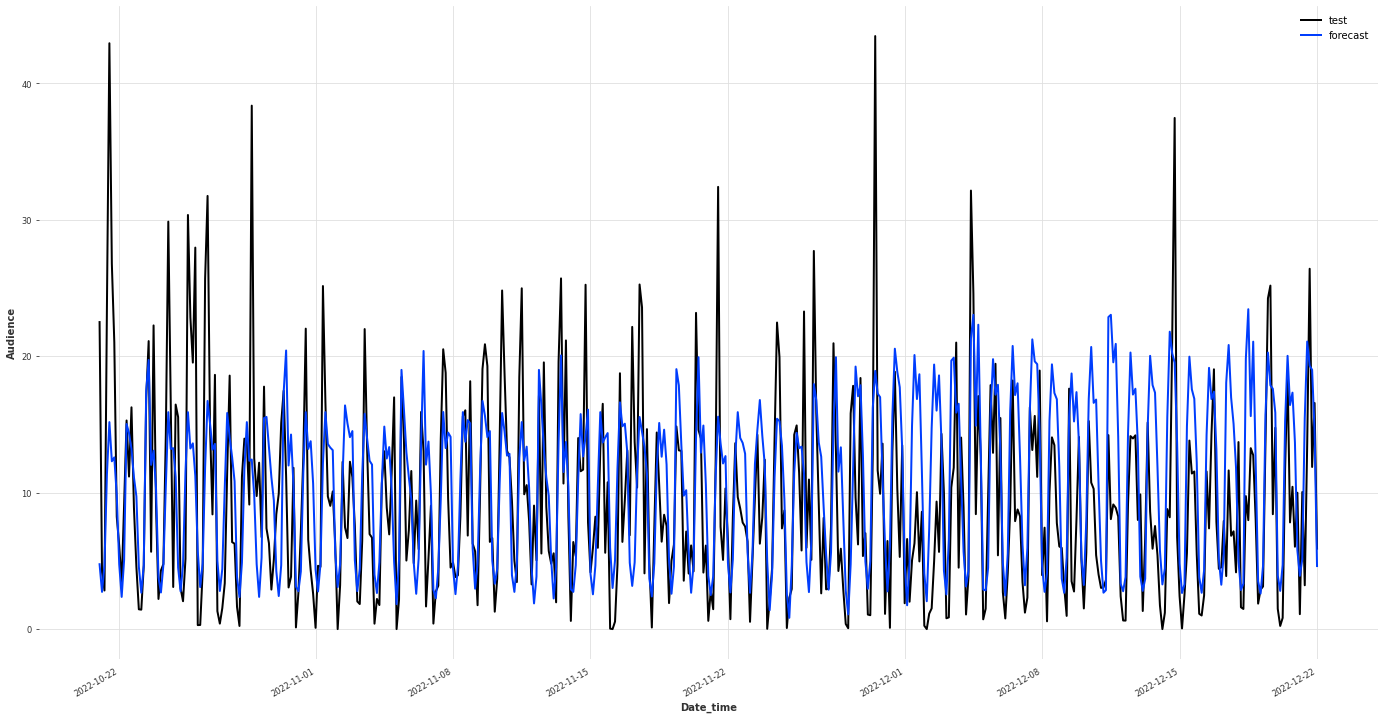

In [334]:
fig, ax = plt.subplots(figsize=(24, 12))

predykcjareg_series["Audience"].plot(ax=ax, label='test')
predykcjareg_series["Predykcja"].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

### 6.4.1 Metryki

In [145]:
darts.metrics.metrics.mae(predykcjareg_series["Audience"], predykcjareg_series["Predykcja"], intersect=True)

4.844081050164067

In [146]:
darts.metrics.metrics.mse(predykcjareg_series["Audience"], predykcjareg_series["Predykcja"], intersect=True)

40.497309756216886

In [147]:
darts.metrics.metrics.r2_score(predykcjareg_series["Audience"], predykcjareg_series["Predykcja"], intersect=True)

0.24244660815351637

In [148]:
darts.metrics.metrics.rmse(predykcjareg_series["Audience"], predykcjareg_series["Predykcja"], intersect=True)

6.363749661655217

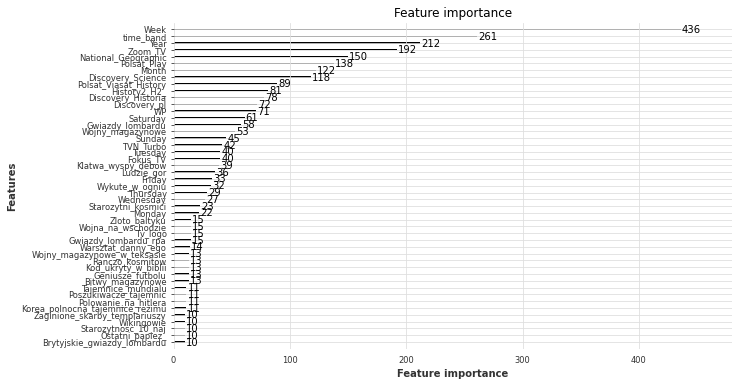

In [149]:
lgbm.plot_importance(modelreg, max_num_features=47, figsize=(10,6))
plt.show()

In [150]:
modelreg2 = LGBMRegressor(
        num_leaves=32,
        max_depth=-1,
        min_child_samples=10,
        learning_rate=0.1,
        n_estimators=100,
        )

In [151]:
modelreg2.fit(trainreg.drop(["Day_of_week","Date_time", "Share", "Audience"], axis=1), trainreg["Share"])

LGBMRegressor(min_child_samples=10, num_leaves=32)

In [152]:
predykcjareg2 = modelreg2.predict(testreg.drop(["Day_of_week", "Date_time", "Share", "Audience"], axis=1))

In [153]:
predykcjareg_compare2 = testreg[['Date_time', 'Share']]
predykcjareg_compare2['Predykcja'] = predykcjareg2
predykcjareg_compare2

C:\Users\asus\AppData\Local\Temp\ipykernel_14056\3194966392.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date_time     Share  Predykcja
time                                          
14112 2022-10-21 00:00:00  2.280000   0.484746
14113 2022-10-21 03:00:00  1.141500   0.530190
14114 2022-10-21 06:00:00  0.166333   0.375726
14115 2022-10-21 09:00:00  1.153667   0.498783
14116 2022-10-21 12:00:00  2.023429   0.584274
...                   ...       ...        ...
14604 2022-12-21 12:00:00  0.523857   0.840509
14605 2022-12-21 15:00:00  0.744250   0.529757
14606 2022-12-21 18:00:00  0.199333   0.267945
14607 2022-12-21 21:00:00  0.366250   0.274163
14608 2022-12-22 00:00:00  0.513667   0.627100

[497 rows x 3 columns]

In [338]:
predykcjareg_compare2.set_index(predykcjareg_compare2["Date_time"], inplace=True)
targeter2 = ['Predykcja', 'Share']
predykcjareg_series2 = darts.TimeSeries.from_dataframe(predykcjareg_compare2[targeter2])

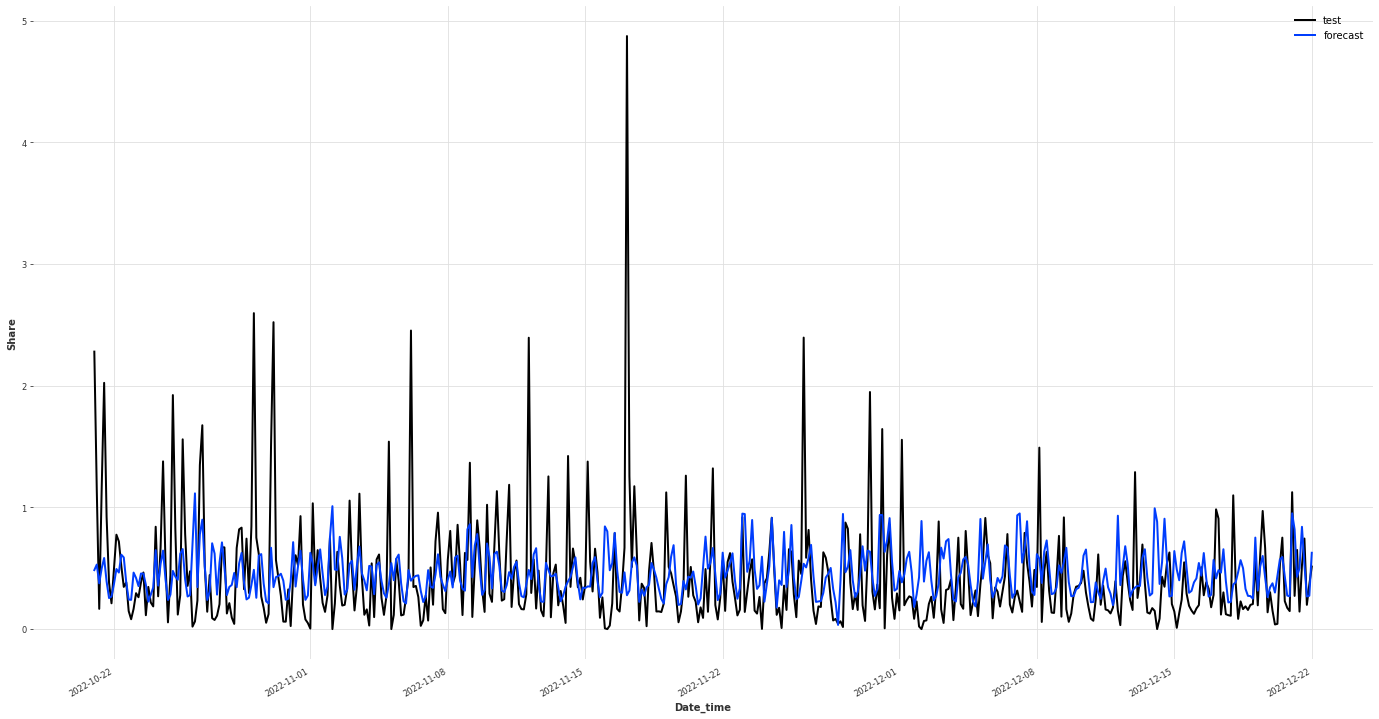

In [339]:
fig, ax = plt.subplots(figsize=(24, 12))

predykcjareg_series2["Share"].plot(ax=ax, label='test')
predykcjareg_series2["Predykcja"].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Share')
plt.show()

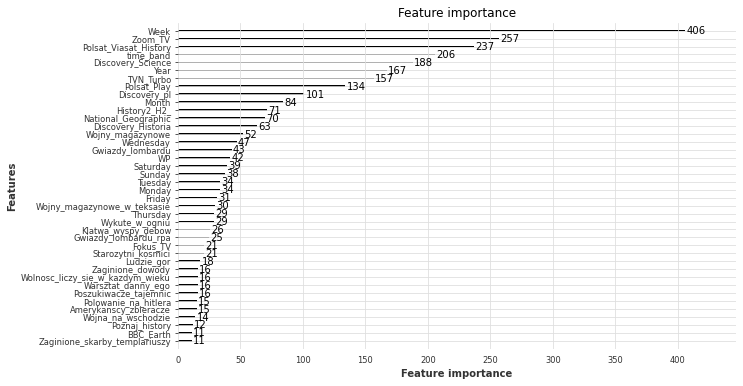

In [160]:
lgbm.plot_importance(modelreg2, max_num_features=40, figsize=(10,6))
plt.show()

In [162]:
Regressor2 = Regressor.drop(["Day_of_week","Date_time", "Share", "Audience"], axis=1)

In [163]:
threshold = 10
less_important_features = np.where(modelreg.feature_importances_ < threshold)[0]
high_important_features = np.where(modelreg.feature_importances_ > threshold)[0]

In [164]:
less_important_features

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  46,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  65,  66,  67,  68,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       187, 188, 189, 190, 191, 192, 193, 195, 196, 199, 200, 20

In [165]:
high_important_features

array([ 16,  45,  47,  48,  63,  64,  69,  79, 132, 135, 145, 157, 164,
       175, 186, 197, 198, 201, 209, 221, 231, 232, 233, 234, 235, 236,
       237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253], dtype=int64)

In [166]:
Regressor2.drop(Regressor2.columns[less_important_features], axis=1, inplace=True)

In [167]:
Regressor2['Audience'] = Regressor['Audience']
Regressor2['Share'] = Regressor['Share']
Regressor2['Date_time'] = Regressor['Date_time']

In [168]:
Regressor2.set_index(Regressor2.columns[-1], inplace=True)

In [169]:
Regressor2

Bitwy_magazynowe  Brytyjskie_gwiazdy_lombardu  \
Date_time                                                            
2017-12-22 00:00:00               0.0                          0.0   
2017-12-22 03:00:00               0.0                          0.0   
2017-12-22 06:00:00               0.0                          0.0   
2017-12-22 09:00:00               0.0                          0.0   
2017-12-22 12:00:00               0.0                          0.0   
...                               ...                          ...   
2022-12-21 12:00:00               1.0                          0.0   
2022-12-21 15:00:00               1.0                          0.0   
2022-12-21 18:00:00               0.0                          0.0   
2022-12-21 21:00:00               0.0                          0.0   
2022-12-22 00:00:00               0.0                          0.0   

                     Geniusze_futbolu  Gwiazdy_lombardu  Gwiazdy_lombardu_rpa  \
Date_time                                                                       
2017-12-22 00:00:00               0.0               0.0                   0.0   
2017-12-22 03:00:00               0.0               1.0                   0.0   
2017-12-22 06:00:00               0.0               0.0                   0.0   
2017-12-22 09:00:00               0.0               1.0                   0.0   
2017-12-22 12:00:00               0.0               1.0                   0.0   
...                               ...               ...                   ...   
2022-12-21 12:00:00               0.0               0.0                   0.0   
2022-12-21 15:00:00               0.0               0.0                   0.0   
2022-12-21 18:00:00               0.0               0.0                   0.0   
2022-12-21 21:00:00               0.0               0.0                   0.0   
2022-12-22 00:00:00               0.0               0.0                   0.0   

                     Klatwa_wyspy_debow  Kod_ukryty_w_biblii  \
Date_time                                                      
2017-12-22 00:00:00                 0.0                  0.0   
2017-12-22 03:00:00                 0.0                  0.0   
2017-12-22 06:00:00                 0.0                  0.0   
2017-12-22 09:00:00                 0.0                  0.0   
2017-12-22 12:00:00                 0.0                  0.0   
...                                 ...                  ...   
2022-12-21 12:00:00                 0.0                  0.0   
2022-12-21 15:00:00                 0.0                  0.0   
2022-12-21 18:00:00                 0.0                  0.0   
2022-12-21 21:00:00                 0.0                  0.0   
2022-12-22 00:00:00                 0.0                  0.0   

                     Korea_polnocna_tajemnice_rezimu  Ludzie_gor  \
Date_time                                                          
2017-12-22 00:00:00                              0.0         1.0   
2017-12-22 03:00:00                              0.0         0.0   
2017-12-22 06:00:00                              0.0         1.0   
2017-12-22 09:00:00                              0.0         1.0   
2017-12-22 12:00:00                              0.0         0.0   
...                                              ...         ...   
2022-12-21 12:00:00                              0.0         0.0   
2022-12-21 15:00:00                              0.0         1.0   
2022-12-21 18:00:00                              0.0         1.0   
2022-12-21 21:00:00                              0.0         0.0   
2022-12-22 00:00:00                              0.0         1.0   

                     Ostatni_papiez_  ...  Saturday  Sunday  Thursday  \
Date_time                             ...                               
2017-12-22 00:00:00              0.0  ...         0       0         0   
2017-12-22 03:00:00              0.0  ...         0       0         0   
2017-12-22 06:00:00              0.0  ...     

In [170]:
testfin = Regressor2['2022-10-21':] # podział testowych danych na ostatnie dwa miesiące, gdyż taki okres będzie potrzebny do predykcji potem
trainfin = Regressor2[:'2022-10-20']
featuresdffin = Regressor2.drop(['Share', 'Audience'], axis = 1) #zrobić listę kolumn

featuresfin = list(featuresdffin.columns)
targetfin = ['Share', 'Audience']
target_ts_testfin = darts.TimeSeries.from_dataframe(testfin[targetfin])
feature_ts_testfin = darts.TimeSeries.from_dataframe(Regressor2[featuresfin])
target_ts_trainfin = darts.TimeSeries.from_dataframe(trainfin[targetfin])
feature_ts_trainfin = darts.TimeSeries.from_dataframe(trainfin[featuresfin])

## 6.5 Model darts LightGBM po odsianiu teorertycznie mniej istotnych feature'ów.

In [172]:
model3 = LightGBMModel(
        lags=52,
        lags_past_covariates=8,
        lags_future_covariates=(16,8), 
        output_chunk_length=len(target_ts_testfin),
        add_encoders=None,
        likelihood=None,
        quantiles=None,
        random_state=None,
        )

In [174]:
model3.fit(target_ts_trainfin, feature_ts_trainfin, feature_ts_testfin)

In [217]:
#with open('model3_fut_cov.pkl', 'wb') as f3:
 #   pickle.dump(model3, f3)

In [175]:
with open('model3_fut_cov.pkl', 'rb') as f3:
    model3 = pickle.load(f3)

In [176]:
predykcja3 = model3.predict(len(target_ts_testfin), target_ts_trainfin, feature_ts_trainfin, feature_ts_testfin)

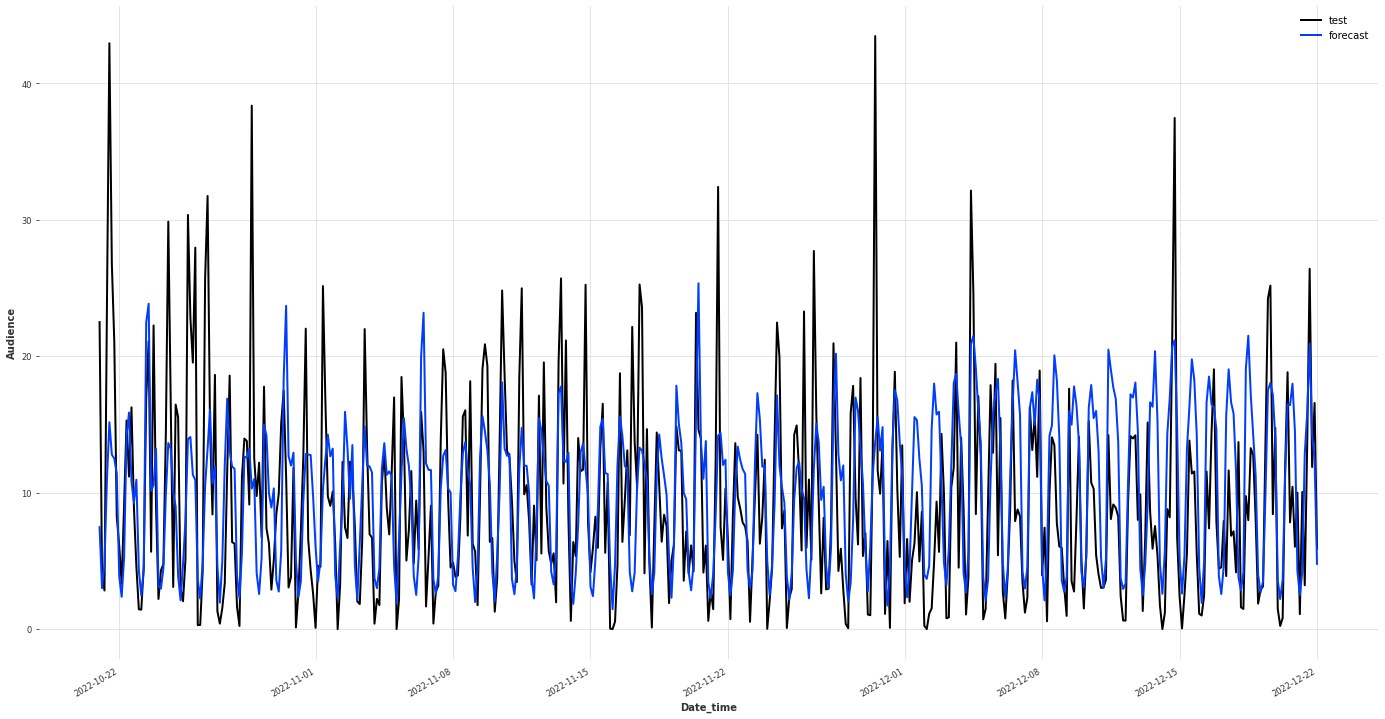

In [337]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_testfin['Audience'].plot(ax=ax, label='test')
predykcja3['Audience'].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

In [187]:
predykcja3df = predykcja3.pd_dataframe()
target_ts_testfindf = target_ts_testfin.pd_dataframe()

In [188]:
Compare3 = pd.merge(target_ts_testfindf['Audience'], predykcja3df['Audience'], left_index=True, right_on='Date_time', how='left')
Compare3.tail(60)

Audience_x  Audience_y
Date_time                                  
2022-12-14 15:00:00   21.272250   20.723970
2022-12-14 18:00:00   37.457000   21.163637
2022-12-14 21:00:00    6.754500   14.855294
2022-12-15 00:00:00    2.417400    5.149201
2022-12-15 03:00:00    0.047250    2.605768
2022-12-15 06:00:00    2.519167    5.391341
2022-12-15 09:00:00    5.559667   13.192692
2022-12-15 12:00:00   13.815857   16.266596
2022-12-15 15:00:00   11.399250   19.772185
2022-12-15 18:00:00   11.551333   18.263500
2022-12-15 21:00:00    5.465000   14.212140
2022-12-16 00:00:00    1.119200    4.506269
2022-12-16 03:00:00    0.997250    1.921415
2022-12-16 06:00:00    2.477833    4.912771
2022-12-16 09:00:00   11.551167   16.612476
2022-12-16 12:00:00    7.380714   18.504022
2022-12-16 15:00:00   14.283250   16.468450
2022-12-16 18:00:00   19.037667   16.261919
2022-12-16 21:00:00    7.866000   14.614209
2022-12-17 00:00:00    4.419000    3.891542
2022-12-17 03:00:00    4.528833    2.565598
2022-12-17 06:00:00    7.926800    4.620847
2022-12-17 09:00:00    3.884714   15.646158
2022-12-17 12:00:00   11.627000   19.034832
2022-12-17 15:00:00    6.837333   16.600815
2022-12-17 18:00:00    7.166333   15.793237
2022-12-17 21:00:00    4.158500   11.576871
2022-12-18 00:00:00   13.705500    3.803587
2022-12-18 03:00:00    1.599600    2.835111
2022-12-18 06:00:00    1.475000    4.134708
2022-12-18 09:00:00    9.744667   19.054244
2022-12-18 12:00:00    7.983500   21.500684
2022-12-18 15:00:00   13.259333   17.174447
2022-12-18 18:00:00   12.743500   14.186109
2022-12-18 21:00:00    8.042000   11.253746
2022-12-19 00:00:00    1.867500    3.977891
2022-12-19 03:00:00    2.890000    2.684355
2022-12-19 06:00:00    3.124333    3.500682
2022-12-19 09:00:00   13.616000    9.907769
2022-12-19 12:00:00   24.233571   17.509515
2022-12-19 15:00:00   25.171000   18.029366
2022-12-19 18:00:00    8.418333   17.179673
2022-12-19 21:00:00   14.754000   13.952701
2022-12-20 00:00:00    1.484400    3.565200
2022-12-20 03:00:00    0.231250    2.203658
2022-12-20 06:00:00    0.822333    3.608773
2022-12-20 09:00:00   11.786333   11.212549
2022-12-20 12:00:00   18.820857   16.493210
2022-12-20 15:00:00    7.818250   16.415851
2022-12-20 18:00:00   10.428333   17.982103
2022-12-20 21:00:00    6.036250   14.468874
2022-12-21 00:00:00    9.992600    4.261160
2022-12-21 03:00:00    1.094000    2.500743
2022-12-21 06:00:00   10.044667    4.206337
2022-12-21 09:00:00    3.211167   12.831588
2022-12-21 12:00:00   13.609429   15.839501
2022-12-21 15:00:00   26.405750   20.916060
2022-12-21 18:00:00   11.880333   14.214820
2022-12-21 21:00:00   16.568750   12.499092
2022-12-22 00:00:00    5.893667    4.779393

# 8. Podsumowanie i interpretacja wyników.

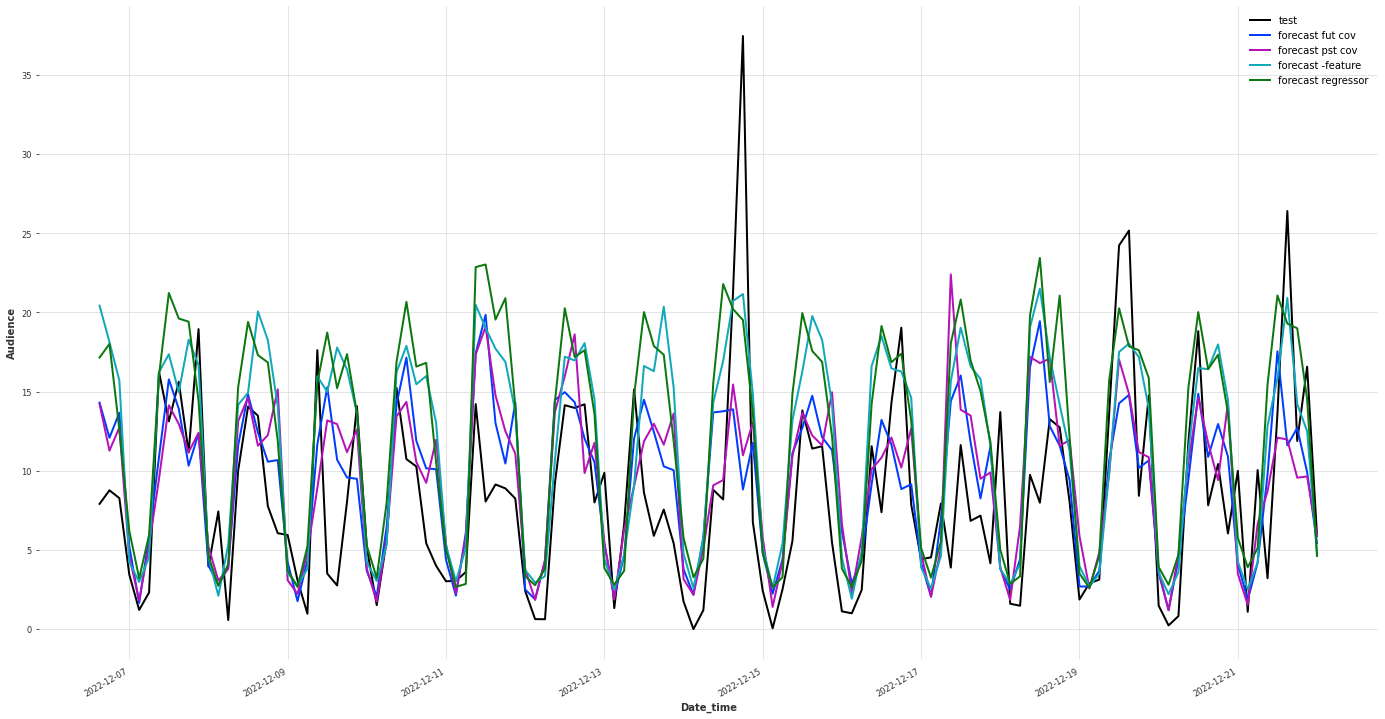

In [320]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][-124:].plot(ax=ax, label='test')
predykcja2['Audience'][-124:].plot(ax=ax, label='forecast fut cov')
predykcja['Audience'][-124:].plot(ax=ax, label='forecast pst cov')
predykcja3['Audience'][-124:].plot(ax=ax, label='forecast -feature')
predykcjareg_series["Predykcja"][-124:].plot(ax=ax, label='forecast regressor')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

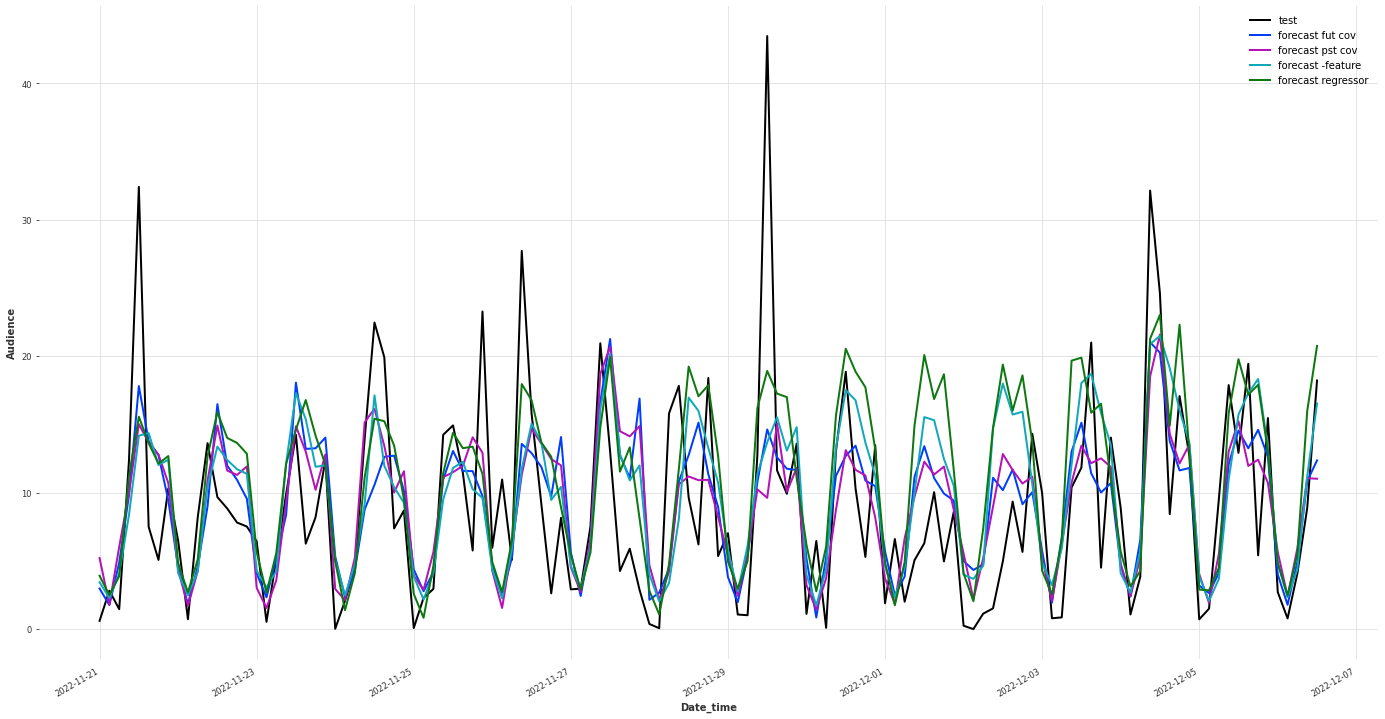

In [321]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][248:-124].plot(ax=ax, label='test')
predykcja2['Audience'][248:-124].plot(ax=ax, label='forecast fut cov')
predykcja['Audience'][248:-124].plot(ax=ax, label='forecast pst cov')
predykcja3['Audience'][248:-124].plot(ax=ax, label='forecast -feature')
predykcjareg_series["Predykcja"][248:-124].plot(ax=ax, label='forecast regressor')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

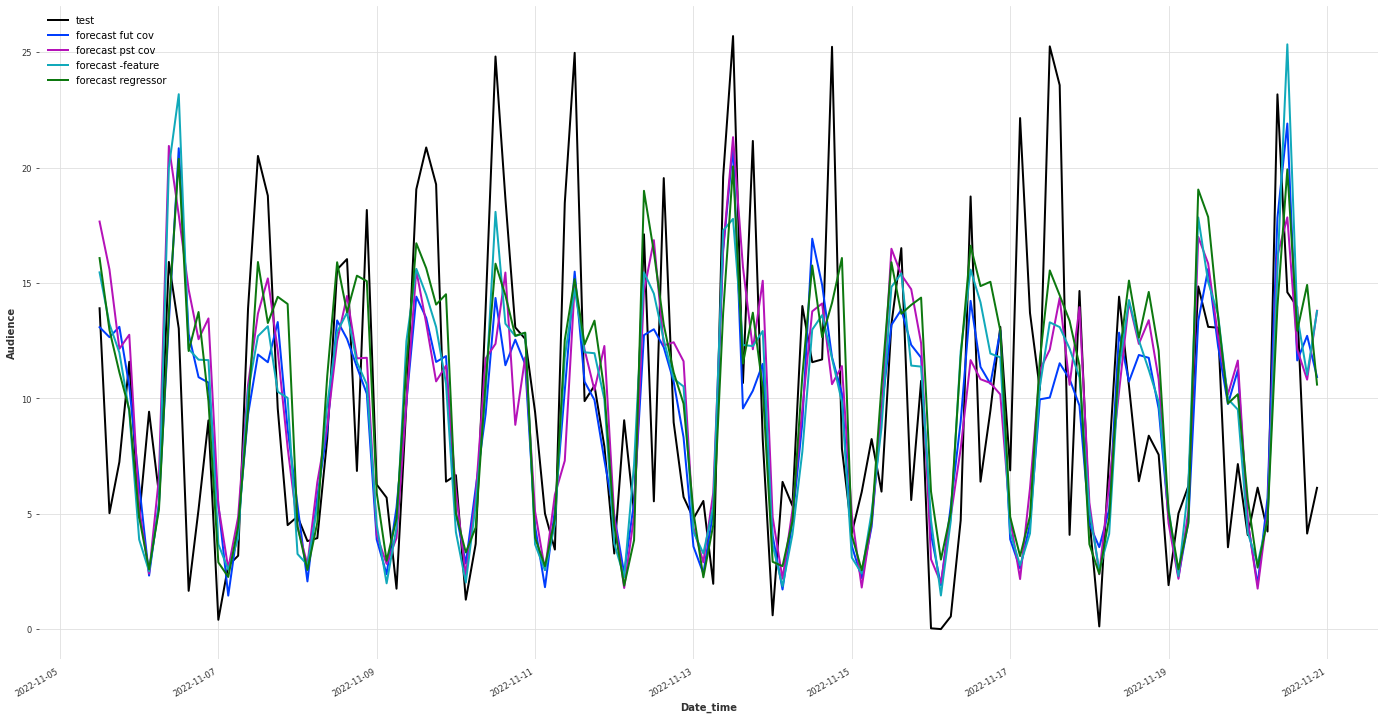

In [322]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][124:248].plot(ax=ax, label='test')
predykcja2['Audience'][124:248].plot(ax=ax, label='forecast fut cov')
predykcja['Audience'][124:248].plot(ax=ax, label='forecast pst cov')
predykcja3['Audience'][124:248].plot(ax=ax, label='forecast -feature')
predykcjareg_series["Predykcja"][124:248].plot(ax=ax, label='forecast regressor')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

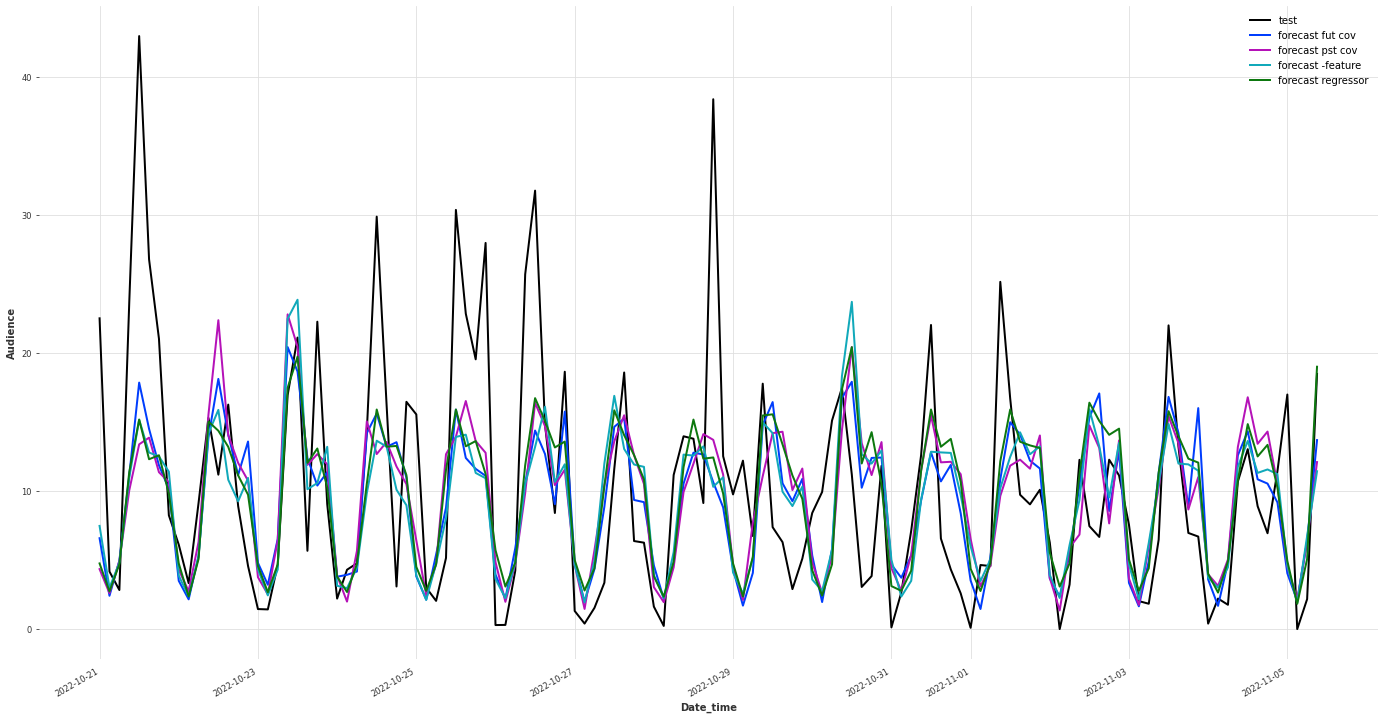

In [323]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_test['Audience'][:124].plot(ax=ax, label='test')
predykcja2['Audience'][:124].plot(ax=ax, label='forecast fut cov')
predykcja['Audience'][:124].plot(ax=ax, label='forecast pst cov')
predykcja3['Audience'][:124].plot(ax=ax, label='forecast -feature')
predykcjareg_series["Predykcja"][:124].plot(ax=ax, label='forecast regressor')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

In [ ]:
# porówananie metryk liczbowych w tabelce

# 9. Weryfikacja najlepszego otrzymanego modelu na nowych danych telemetrycznych.

## 9.1 Wczytywanie ramówki na kolejne dwa miesiące i przygotowanie zbioru do weryfikacji modelu.

In [365]:
data_val = pd.read_csv("Zbior walidacyjny.txt")

In [366]:
data_val = pd.DataFrame(data_val)
data_val

Channel Group ...        Date Start time              Programme Title  \
0                 History  2022-12-22   02:00:00                   Ludzie gor   
1                 History  2022-12-22   02:45:00                   Ludzie gor   
2                 History  2022-12-22   03:40:00                   Ludzie gor   
3                 History  2022-12-22   04:35:00  Wojny magazynowe w teksasie   
4                 History  2022-12-22   05:00:00   Wojny magazynowe nowy jork   
...                   ...         ...        ...                          ...   
29484  Discovery Historia  2023-02-28   22:00:00              Akcja innowacja   
29485  Discovery Historia  2023-02-28   23:00:00               Zdobywcy nieba   
29486  Discovery Historia  2023-02-28   23:30:00               Zdobywcy nieba   
29487  Discovery Historia  2023-02-28   24:00:00   Tajemnice slynnych budowli   
29488  Discovery Historia  2023-02-28   25:00:00   Tajemnice slynnych budowli   

       '000 (avg)  Prog Share  
0          16.456       1.941  
1          11.909       2.069  
2           0.000       0.000  
3           0.666       0.151  
4           0.000       0.000  
...           ...         ...  
29484       0.140       0.003  
29485       0.000       0.000  
29486       0.000       0.000  
29487       0.760       0.042  
29488       1.441       0.142  

[29489 rows x 6 columns]

In [367]:
data_val["Date"] = pd.to_datetime(data_val["Date"])
data_val.insert(1, "Start_time_real", "") 
data_val.insert(1, "Date_real", "") 

In [368]:
for i in data_val.index:
    if data_val["Start time"][i][:2] == '24':
        a = ("00" + data_val["Start time"][i][2:])
        b = data_val["Date"][i] + timedelta(days=1)
        data_val.at[i, 'Start_time_real'] = a
        data_val.at[i, 'Date_real'] = b
    elif data_val["Start time"][i][:2] == '25':
        a = ("01" + data_val["Start time"][i][2:])
        b = data_val["Date"][i] + timedelta(days=1)
        data_val.at[i, 'Start_time_real'] = a
        data_val.at[i, 'Date_real'] = b       
    else:
        a = data_val["Start time"][i]
        b = data_val["Date"][i]
        data_val.at[i, 'Start_time_real'] = a
        data_val.at[i, 'Date_real'] = b

In [369]:
data_val['Date_real'] = pd.to_datetime(data_val['Date_real'])
data_val["Date_time"] = pd.to_datetime(data_val['Date_real'] + pd.to_timedelta(data_val["Start_time_real"]))

In [370]:
work_val = data_val

In [371]:
work_val = work_val.drop('Date', axis = 1)
work_val = work_val.drop('Start time', axis = 1)
work_val = work_val.rename(columns={"Channel Group ...": "Channel", "Prog Share": "Share", "Programme Title": "Title", "'000 (avg)": "Audience"})

In [372]:
work_val["Title"].str.contains("Blad w emisji").value_counts()

False    29487
True         2
Name: Title, dtype: int64

In [375]:
work_val = work_val[work_val["Title"].str.contains("Blad w emisji") == False]  # czyszczenie danych z błędów emisyjnych

In [376]:
work_val["Title"].str.contains("Blad w emisji").value_counts()

False    29487
Name: Title, dtype: int64

In [379]:
History_val = work_val[work_val["Channel"] == "History"] 
History_val = History_val.drop(['Start_time_real','Channel'], axis = 1)
History_val

Date_real                             Title  Audience  Share  \
0    2022-12-22                        Ludzie gor    16.456  1.941   
1    2022-12-22                        Ludzie gor    11.909  2.069   
2    2022-12-22                        Ludzie gor     0.000  0.000   
3    2022-12-22       Wojny magazynowe w teksasie     0.666  0.151   
4    2022-12-22        Wojny magazynowe nowy jork     0.000  0.000   
...         ...                               ...       ...    ...   
2638 2023-02-28    Niewyjasnione tajemnice swiata    10.466  0.340   
2639 2023-02-28                   Jak to wyjasnic    19.212  0.902   
2640 2023-03-01                   Jak to wyjasnic    24.851  1.534   
2641 2023-03-01  Trojkat bermudzki przeklete wody    16.585  1.452   
2642 2023-03-01                        Ludzie gor    16.086  1.926   

               Date_time  
0    2022-12-22 02:00:00  
1    2022-12-22 02:45:00  
2    2022-12-22 03:40:00  
3    2022-12-22 04:35:00  
4    2022-12-22 05:00:00  
...                  ...  
2638 2023-02-28 23:00:00  
2639 2023-02-28 23:55:00  
2640 2023-03-01 00:25:00  
2641 2023-03-01 00:50:00  
2642 2023-03-01 01:45:00  

[2642 rows x 5 columns]

In [381]:
History_val_agg = History_val[['Date_time', 'Share', 'Title']]
df_val_agg = History_val_agg.groupby([pd.Grouper(key='Date_time', freq='3H'), 'Title'])['Share'].mean().reset_index()

time_index_val = pd.date_range(start=df_val_agg['Date_time'].min(), end=df_val_agg['Date_time'].max(), freq='3H')
time_df_val = pd.DataFrame(index=time_index_val)

df_val_agg.set_index('Date_time', inplace=True)

program_val_df = pd.get_dummies(df_val_agg['Title'])

In [383]:
channel_val_avg_shr = work_val.groupby('Channel')['Share'].mean().reset_index() 
channel_val_avg_shr = pd.DataFrame(channel_val_avg_shr)

In [384]:
work_val_agg = work_val[['Date_time', 'Share', 'Title', 'Channel']]
work_val_agg = work_val_agg.groupby([pd.Grouper(key='Date_time', freq='3H'), 'Title', 'Channel'])['Share'].mean().reset_index()
work_val_agg1 = work_val_agg.drop(['Share'], axis = 1)
work_val_agg_merged = pd.merge(work_val_agg1, heat_titles, on='Title')

work_val_agg_merged = work_val_agg_merged.drop(['Share', 'Title'], axis = 1) 
work_val_agg_grouped = work_val_agg_merged.groupby([pd.Grouper(key='Date_time', freq='3H'), pd.Grouper(key='Channel')])['Heat'].mean().reset_index()
pivot_val_chdf = work_val_agg_grouped.pivot(index='Date_time', columns='Channel', values='Heat')

for i in channel_val_avg_shr.index:
    if (channel_val_avg_shr['Channel'][i] == "History") or (channel_val_avg_shr['Share'][i] < 0.1):
        name_val = channel_val_avg_shr['Channel'][i]
        pivot_val_chdf = pivot_val_chdf.drop(str(name_val), axis = 1)  
        
pivot_val_chdf

Channel              BBC Earth  Discovery Science  Discovery pl  Fokus TV  \
Date_time                                                                   
2022-12-22 00:00:00        0.0                1.0           1.0       1.0   
2022-12-22 03:00:00        0.0                0.5           1.0       1.0   
2022-12-22 06:00:00        0.0                0.5           1.0       1.0   
2022-12-22 09:00:00        0.0                1.0           1.0       1.0   
2022-12-22 12:00:00        0.0                0.5           1.0       1.0   
...                        ...                ...           ...       ...   
2023-02-28 12:00:00        0.0                0.0           1.0       1.0   
2023-02-28 15:00:00        0.0                0.0           1.0       1.0   
2023-02-28 18:00:00        0.0                0.0           1.0       1.0   
2023-02-28 21:00:00        0.0                0.0           1.0       1.0   
2023-03-01 00:00:00        0.0                0.5           1.0       1.0   

Channel              History2 [H2]  National Geographic  Polsat Play  \
Date_time                                                              
2022-12-22 00:00:00       0.000000             1.000000          1.0   
2022-12-22 03:00:00       0.000000             0.666667          1.0   
2022-12-22 06:00:00       0.250000             0.500000          1.0   
2022-12-22 09:00:00       0.000000             0.666667          1.0   
2022-12-22 12:00:00       0.333333             1.000000          1.0   
...                            ...                  ...          ...   
2023-02-28 12:00:00       0.500000             1.000000          1.0   
2023-02-28 15:00:00       0.333333             1.000000          1.0   
2023-02-28 18:00:00       0.000000             0.666667          1.0   
2023-02-28 21:00:00       0.333333             1.000000          1.0   
2023-03-01 00:00:00       0.500000             1.000000          1.0   

Channel              Polsat Viasat Explore  Polsat Viasat History  TVN Turbo  \
Date_time                                                                      
2022-12-22 00:00:00                    0.0               0.000000        1.0   
2022-12-22 03:00:00                    0.0               0.500000        1.0   
2022-12-22 06:00:00                    0.0               0.500000        1.0   
2022-12-22 09:00:00                    0.0               1.000000        1.0   
2022-12-22 12:00:00                    0.0               1.000000        1.0   
...                                    ...                    ...        ...   
2023-02-28 12:00:00                    0.0               0.666667        1.0   
2023-02-28 15:00:00                    0.0               0.000000        1.0   
2023-02-28 18:00:00                    0.0               0.333333        1.0   
2023-02-28 21:00:00                    0.0               0.000000        1.0   
2023-03-01 00:00:00                    0.0               0.000000        1.0   

Channel                    WP   Zoom TV  
Date_time                                
2022-12-22 00:00:00  1.000000  1.000000  
2022-12-22 03:00:00  1.000000  1.000000  
2022-12-22 06:00:00  0.333333  0.200000  
2022-12-22 09:00:00  1.000000  0.666667  
2022-12-22 12:00:00  1.000000  1.000000  
...                       ...       ...  
2023-02-28 12:00:00  1.000000  0.500000  
2023-02-28 15:00:00  1.000000  1.000000  
2023-02-28 18:00:00  1.000000  1.000000  
2023-02-28 21:00:00  1.000000  1.000000  
2023-03-01 00:00:00  1.000000  1.000000  

[553 rows x 12 columns]

In [386]:
History_val_granulated = History_val[['Date_time', 'Share', 'Audience']]
History_val_granulated.set_index('Date_time', inplace=True)
History_val_granulated = History_val_granulated.resample('3H').mean()
History_val_granulated['Share'].fillna(0, inplace=True)
History_val_granulated['Audience'].fillna(0, inplace=True)

In [392]:
result_val = pd.merge(time_df_val, program_val_df, left_index=True, right_on='Date_time', how='left') 
result_val = result_val.fillna(0)
result_val = result_val.groupby(level=0).sum()
result_val

Amerykanscy zbieracze  Bitwy magazynowe  \
Date_time                                                      
2022-12-22 00:00:00                      0                 0   
2022-12-22 03:00:00                      0                 0   
2022-12-22 06:00:00                      0                 1   
2022-12-22 09:00:00                      0                 1   
2022-12-22 12:00:00                      0                 1   
...                                    ...               ...   
2023-02-28 12:00:00                      0                 1   
2023-02-28 15:00:00                      0                 1   
2023-02-28 18:00:00                      0                 0   
2023-02-28 21:00:00                      0                 0   
2023-03-01 00:00:00                      0                 0   

                     Brac czy nie brac  Dolny slask zaginione skarby  \
Date_time                                                              
2022-12-22 00:00:00                  0                             0   
2022-12-22 03:00:00                  0                             0   
2022-12-22 06:00:00                  0                             0   
2022-12-22 09:00:00                  0                             0   
2022-12-22 12:00:00                  0                             0   
...                                ...                           ...   
2023-02-28 12:00:00                  0                             0   
2023-02-28 15:00:00                  0                             0   
2023-02-28 18:00:00                  0                             0   
2023-02-28 21:00:00                  0                             0   
2023-03-01 00:00:00                  0                             0   

                     Gwiazdy lombardu  Historia broni  \
Date_time                                               
2022-12-22 00:00:00                 0               0   
2022-12-22 03:00:00                 0               0   
2022-12-22 06:00:00                 0               0   
2022-12-22 09:00:00                 0               0   
2022-12-22 12:00:00                 0               0   
...                               ...             ...   
2023-02-28 12:00:00                 0               0   
2023-02-28 15:00:00                 0               0   
2023-02-28 18:00:00                 0               0   
2023-02-28 21:00:00                 0               0   
2023-03-01 00:00:00                 0               0   

                     Hitler jak zostalem dyktatorem  \
Date_time                                             
2022-12-22 00:00:00                               0   
2022-12-22 03:00:00                               0   
2022-12-22 06:00:00                               0   
2022-12-22 09:00:00                               0   
2022-12-22 12:00:00                               0   
...                                             ...   
2023-02-28 12:00:00                               0   
2023-02-28 15:00:00                               0   
2023-02-28 18:00:00                               0   
2023-02-28 21:00:00                               0   
2023-03-01 00:00:00                               0   

                     Hitler mroczny urok dyktatora  Jak to wyjasnic  \
Date_time                                                             
2022-12-22 00:00:00                              0                0   
2022-12-22 03:00:00                              0                0   
2022-12-22 06:00:00                              0                0   
2022-12-22 09:00:00                              0                0   
2022-12-22 12:00:00                              0                0   
...                                            ...              ...   
2023-02-28 12:00:00                              0                0   
2023-02-28 15:00:00                              0                0   
2023-02-28 18:00:00                              0                1   
2023-02-28 2

In [428]:
ShareOHE_val_temp = pd.merge(History_val_granulated, result_val, left_index=True, right_on='Date_time', how='left') 
ShareOHE_val = pd.merge(ShareOHE_val_temp, pivot_val_chdf, left_index = True, right_on='Date_time')
ShareOHE_val = ShareOHE_val.fillna(0)
ShareOHE_val = ShareOHE_val[1:] # usunięcie wiersza, który będzie się powtarzał przy łączeniu ramek
ShareOHE_val = ShareOHE_val[:-55] # usunięcie ostatnich wierszy z uwagi na zbyt daleką predykcja (model2 ma horyzont 497)

## 9.2 Walidacja modelu.

<AxesSubplot:xlabel='Date_time'>

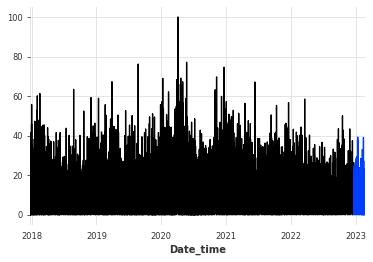

In [429]:
ShareOHE['Audience'].plot(label='train')
ShareOHE_val['Audience'].plot(label='test')

In [430]:
featuresdf_val = ShareOHE.drop(['Share', 'Audience'], axis = 1) #zrobić listę kolumn

features_val = list(featuresdf_val.columns)

In [431]:
ShareOHE_combined = pd.concat([ShareOHE, ShareOHE_val])
ShareOHE_combined = ShareOHE_combined.fillna(0)
ShareOHE_combined

Share   Audience  #liniaprosta  Ale bryka  \
Date_time                                                           
2017-12-22 00:00:00  0.000000   0.000000           0.0        0.0   
2017-12-22 03:00:00  0.083167   0.539000           0.0        0.0   
2017-12-22 06:00:00  0.083750   0.859000           0.0        0.0   
2017-12-22 09:00:00  0.483000  13.179200           0.0        0.0   
2017-12-22 12:00:00  1.361667  41.608833           0.0        0.0   
...                       ...        ...           ...        ...   
2023-02-21 15:00:00  0.413500  16.071000           0.0        0.0   
2023-02-21 18:00:00  0.196250  12.263250           0.0        0.0   
2023-02-21 21:00:00  0.634000  21.630000           0.0        0.0   
2023-02-22 00:00:00  0.624200   6.728400           0.0        0.0   
2023-02-22 03:00:00  0.317800   1.308200           0.0        0.0   

                     Alone: przetrwac najdluzej  Amerykanscy naprawiacze  \
Date_time                                                                  
2017-12-22 00:00:00                         0.0                      0.0   
2017-12-22 03:00:00                         0.0                      0.0   
2017-12-22 06:00:00                         1.0                      0.0   
2017-12-22 09:00:00                         0.0                      0.0   
2017-12-22 12:00:00                         0.0                      0.0   
...                                         ...                      ...   
2023-02-21 15:00:00                         0.0                      0.0   
2023-02-21 18:00:00                         0.0                      0.0   
2023-02-21 21:00:00                         0.0                      0.0   
2023-02-22 00:00:00                         0.0                      0.0   
2023-02-22 03:00:00                         0.0                      0.0   

                     Amerykanscy zbieracze  Amerykanska ksiega tajemnic  \
Date_time                                                                 
2017-12-22 00:00:00                    0.0                          0.0   
2017-12-22 03:00:00                    0.0                          0.0   
2017-12-22 06:00:00                    0.0                          0.0   
2017-12-22 09:00:00                    0.0                          0.0   
2017-12-22 12:00:00                    0.0                          0.0   
...                                    ...                          ...   
2023-02-21 15:00:00                    0.0                          0.0   
2023-02-21 18:00:00                    0.0                          0.0   
2023-02-21 21:00:00                    0.0                          0.0   
2023-02-22 00:00:00                    0.0                          0.0   
2023-02-22 03:00:00                    0.0                          0.0   

                     Amerykanski rozpruwacz w londynie  Atlantyda odnaleziona  \
Date_time                                                                       
2017-12-22 00:00:00                                0.0                    0.0   
2017-12-22 03:00:00                                0.0                    0.0   
2017-12-22 06:00:00                                0.0                    0.0   
2017-12-22 09:00:00                                0.0                    0.0   
2017-12-22 12:00:00                                0.0                    0.0   
...                                                ...                    ...   
2023-02-21 15:00:00                                0.0                    0.0   
2023-02-21 18:00:00                                0.0                    0.0   
2023-02-21 21:00:00                                0.0                    0.0   
2023-02-22 00:00:00                                0.0                    0.0   
2023-02-22 03:00:00                                0.0                    0.0   

                     ...  National Geographic  Polsat Play  \
Date_time            ...                     

In [432]:
target_ts_val = darts.TimeSeries.from_dataframe(ShareOHE_val[target])
feature_ts_val = darts.TimeSeries.from_dataframe(ShareOHE_combined[features])
target_ts_past = darts.TimeSeries.from_dataframe(ShareOHE[target])
feature_ts_past = darts.TimeSeries.from_dataframe(ShareOHE[features])

In [434]:
predykcja_val = model2.predict(len(target_ts_val), target_ts_past, feature_ts_past, feature_ts_val)

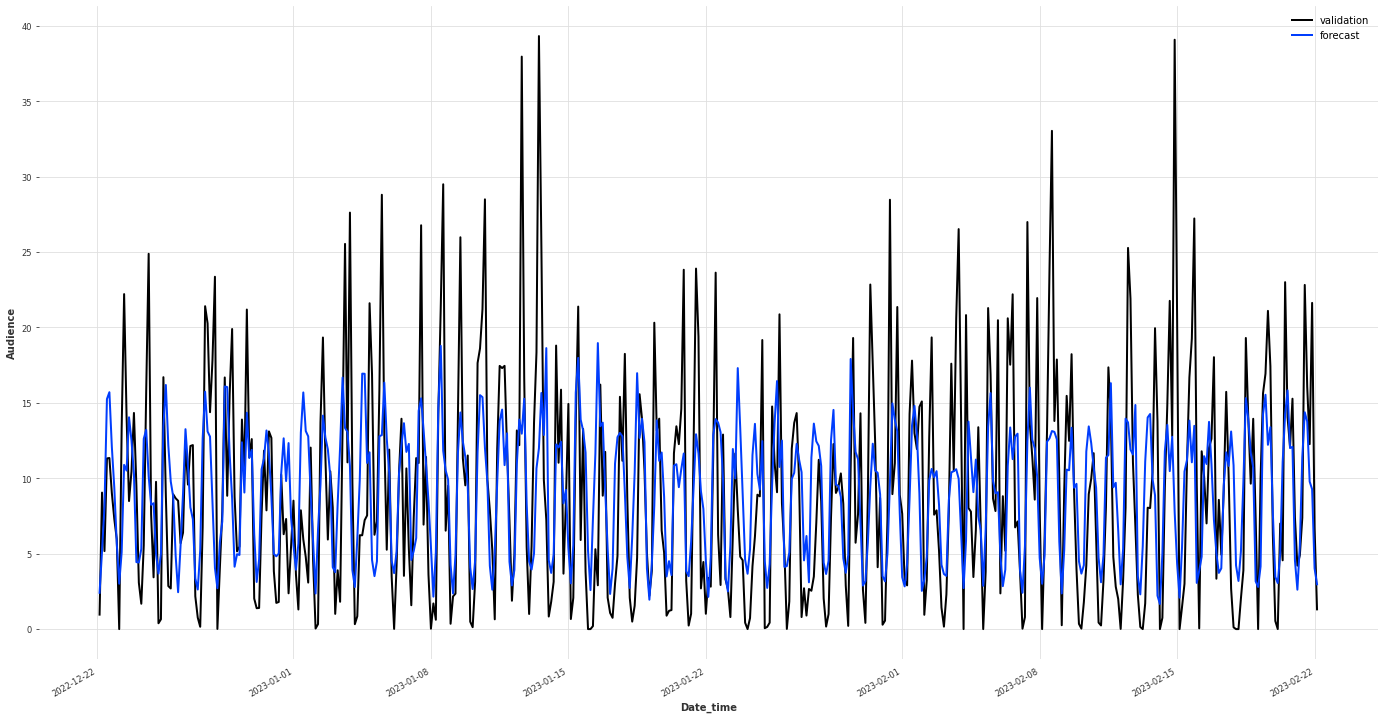

In [436]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_val['Audience'].plot(ax=ax, label='validation')
predykcja_val['Audience'].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

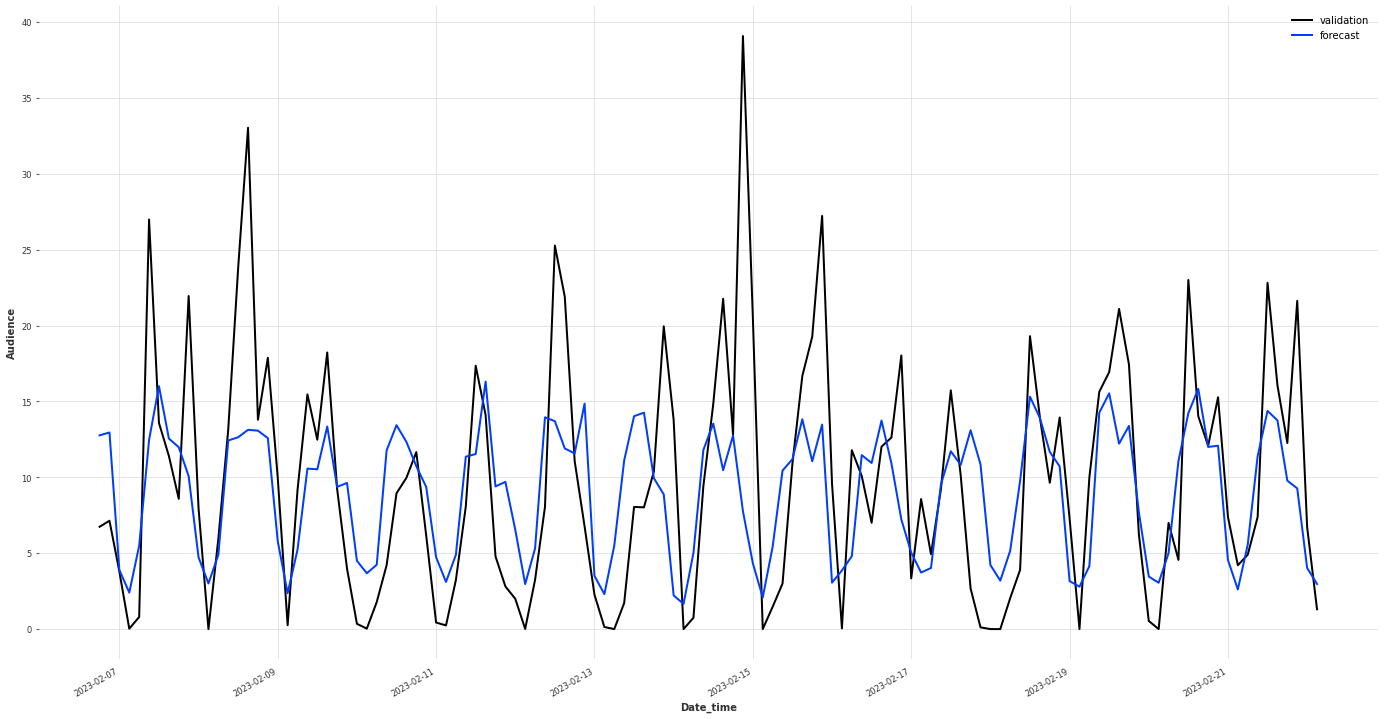

In [445]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_val['Audience'][-124:].plot(ax=ax, label='validation')
predykcja_val['Audience'][-124:].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

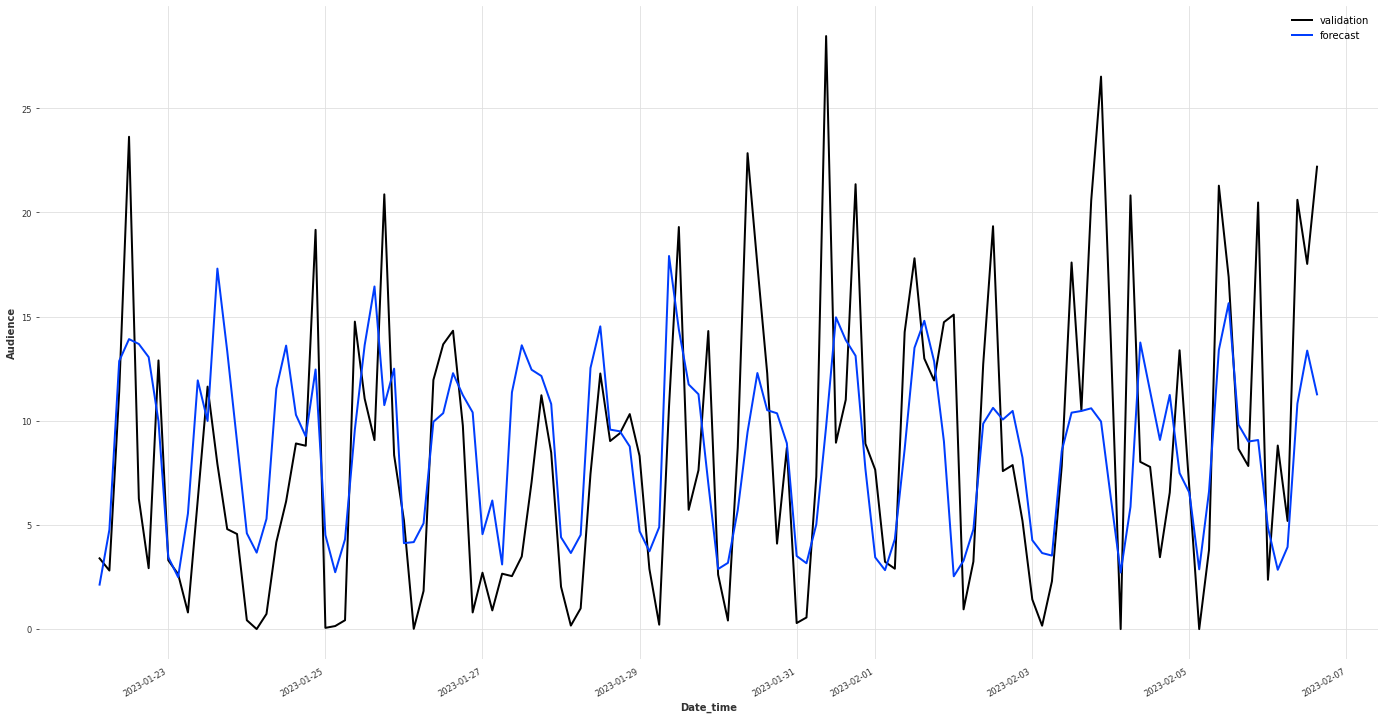

In [446]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_val['Audience'][248:-124].plot(ax=ax, label='validation')
predykcja_val['Audience'][248:-124].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

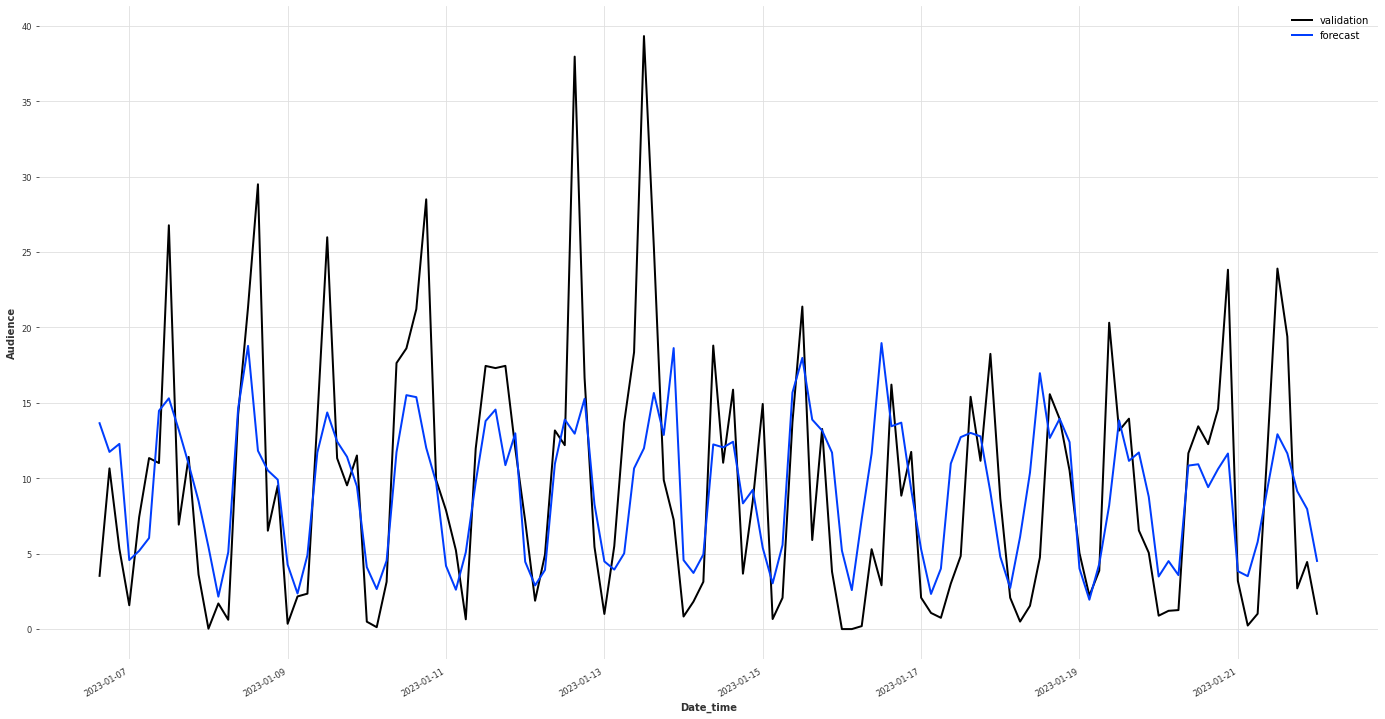

In [447]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_val['Audience'][124:248].plot(ax=ax, label='validation')
predykcja_val['Audience'][124:248].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

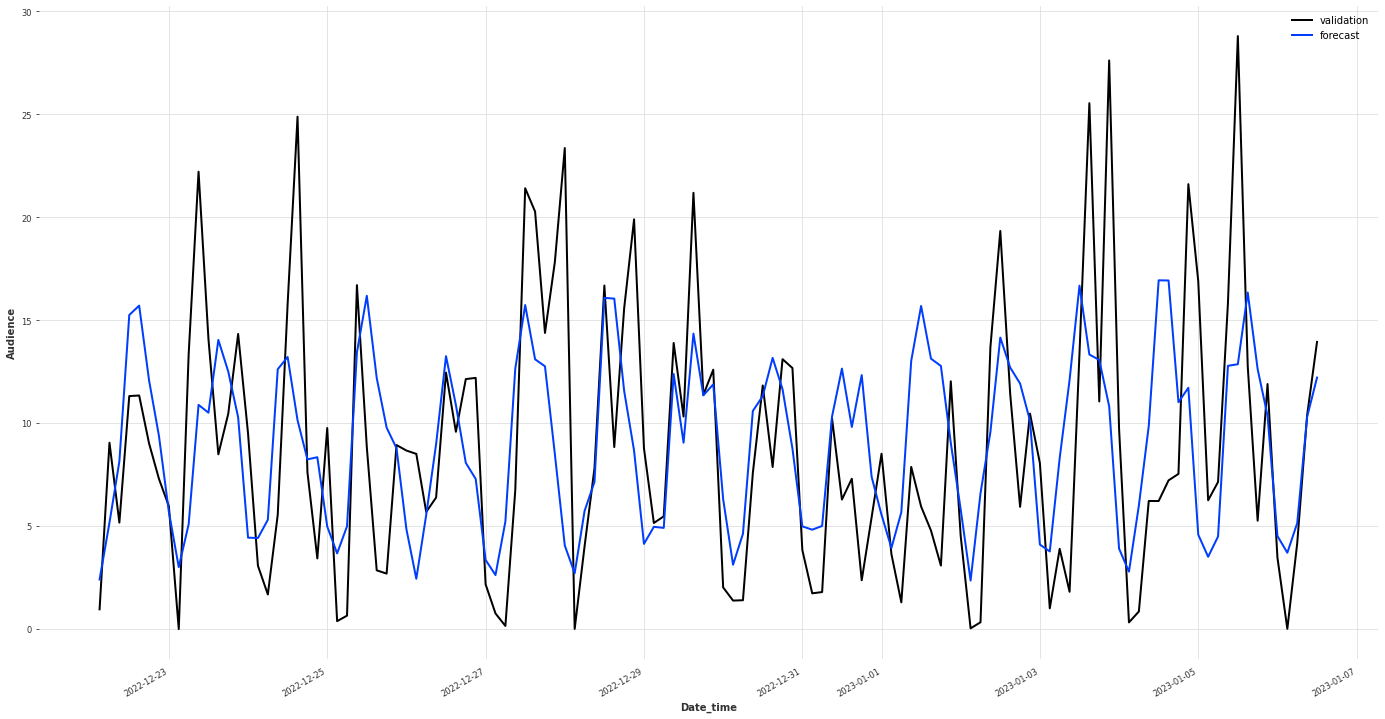

In [448]:
fig, ax = plt.subplots(figsize=(24, 12))

target_ts_val['Audience'][:124].plot(ax=ax, label='validation')
predykcja_val['Audience'][:124].plot(ax=ax, label='forecast')

ax.set_xlabel('Date_time')
ax.set_ylabel('Audience')
plt.show()

In [437]:
darts.metrics.metrics.mae(target_ts_val["Audience"], predykcja_val["Audience"], intersect=True)

4.564902648903264

In [439]:
darts.metrics.metrics.mse(target_ts_val["Audience"], predykcja_val["Audience"], intersect=True)

37.585639461775195

In [441]:
darts.metrics.r2_score(target_ts_val["Audience"], predykcja_val["Audience"])

0.31439550359429724

In [443]:
darts.metrics.metrics.rmse(target_ts_val["Audience"], predykcja_val["Audience"], intersect=True)

6.1307128020952995

In [453]:
predykcja_val_df = predykcja_val.pd_dataframe()
target_ts_val_df = target_ts_val.pd_dataframe()

In [454]:
Compare_val = pd.merge(target_ts_val_df['Audience'], predykcja_val_df['Audience'], left_index=True, right_on='Date_time', how='left')
Compare_val

Audience_x  Audience_y
Date_time                                  
2022-12-22 03:00:00    0.959250    2.407802
2022-12-22 06:00:00    9.051500    5.168096
2022-12-22 09:00:00    5.171167    8.140515
2022-12-22 12:00:00   11.316714   15.254249
2022-12-22 15:00:00   11.344250   15.709075
...                         ...         ...
2023-02-21 15:00:00   16.071000   13.756059
2023-02-21 18:00:00   12.263250    9.780672
2023-02-21 21:00:00   21.630000    9.273050
2023-02-22 00:00:00    6.728400    4.028929
2023-02-22 03:00:00    1.308200    2.971485

[497 rows x 2 columns]

## 9.3 Podsumowanie walidacji modelu.